In [1]:
#https://cooltools.readthedocs.io/en/latest/notebooks/viz.html

#Import the packages we will use
#Utilities
import os
import re
import itertools
from itertools import combinations
import glob
import pickle
import argparse

#Data Management
import numpy as np
from numpy import diff
import pandas as pd
import h5py
import scipy
from scipy.stats import linregress
from scipy import ndimage
from functools import partial
from scipy.linalg import toeplitz

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import seaborn as sns
import upsetplot
from upsetplot import UpSet

#Genomics
import pairtools
import cooler
import cooltools
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
import bioframe
from bioframe import overlap
import bbi
from cooltools import insulation

In [2]:
#Using hg38 aligned files, sampling coolers to same number of interactions between samples/replicates

In [67]:
outDataDir = '../..'
inDataDir = '../../../../geo_upload_hic'

In [68]:
#conditions
conditions = [
    'WT_Ctrl_R1',
    'WT_ATRA_R1',
    'Top2BKO_Ctrl_R1',
    'Top2BKO_ATRA_R1',
    'WT_Ctrl_R2',
    'WT_ATRA_R2',
    'Top2BKO_Ctrl_R2',
    'Top2BKO_ATRA_R2',
    'WT_Ctrl_R1R2',
    'WT_ATRA_R1R2',
    'Top2BKO_Ctrl_R1R2',
    'Top2BKO_ATRA_R1R2'
]

long_names = {
    'WT_Ctrl_R1' : 'CA-HiC-Dpn-SH-SY5Y-WT-Ctrl-4-51-R1-T1',
    'WT_ATRA_R1' : 'CA-HiC-Dpn-SH-SY5Y-WT-ATRA-5days-4-51-R1-T1',
    'Top2BKO_Ctrl_R1' : 'CA-HiC-Dpn-SH-SY5Y-BKO98-Ctrl-4-51-R1-T1',
    'Top2BKO_ATRA_R1' : 'CA-HiC-Dpn-SH-SY5Y-BKO98-ATRA-5days-4-51-R1-T1',
    'WT_Ctrl_R2' : 'CA-HiC-Dpn-SH-SY5Y-WT-Ctrl-4-52-R2-T1',
    'WT_ATRA_R2' : 'CA-HiC-Dpn-SH-SY5Y-WT-ATRA-5days-4-52-R2-T1',
    'Top2BKO_Ctrl_R2' : 'CA-HiC-Dpn-SH-SY5Y-BKO98-Ctrl-4-52-R2-T1',
    'Top2BKO_ATRA_R2' : 'CA-HiC-Dpn-SH-SY5Y-BKO98-ATRA-5days-4-52-R2-T1',
    'WT_Ctrl_R1R2' : 'CA-HiC-Dpn-SH-SY5Y-WT-Ctrl-4-51-and-4-52-R1R2',
    'WT_ATRA_R1R2' : 'CA-HiC-Dpn-SH-SY5Y-WT-ATRA-5days-4-51-and-4-52-R1R2',
    'Top2BKO_Ctrl_R1R2' : 'CA-HiC-Dpn-SH-SY5Y-BKO98-Ctrl-4-51-and-4-52-R1R2',
    'Top2BKO_ATRA_R1R2' : 'CA-HiC-Dpn-SH-SY5Y-BKO98-ATRA-5days-4-51-and-4-52-R1R2'
}

In [69]:
#add colors for each sample
sampleColors = {
    'WT_Ctrl_R1' : '#a6cee3',
    'WT_ATRA_R1' : '#1f78b4',
    'Top2BKO_Ctrl_R1' : '#b2df8a',
    'Top2BKO_ATRA_R1' : '#33a02c',
    'WT_Ctrl_R2' : '#a6cee3',
    'WT_ATRA_R2' : '#1f78b4',
    'Top2BKO_Ctrl_R2' : '#b2df8a',
    'Top2BKO_ATRA_R2' : '#33a02c',
    'WT_Ctrl_R1R2' : '#a6cee3',
    'WT_ATRA_R1R2' : '#1f78b4',
    'Top2BKO_Ctrl_R1R2' : '#b2df8a',
    'Top2BKO_ATRA_R1R2' : '#33a02c'
}

sampleLineStyles = {
    'WT_Ctrl_R1' : '--',
    'WT_ATRA_R1' : '--',
    'Top2BKO_Ctrl_R1' : '--',
    'Top2BKO_ATRA_R1' : '--',
    'WT_Ctrl_R2' : ':',
    'WT_ATRA_R2' : ':',
    'Top2BKO_Ctrl_R2' : ':',
    'Top2BKO_ATRA_R2' : ':',
    'WT_Ctrl_R1R2' : '-',
    'WT_ATRA_R1R2' : '-',
    'Top2BKO_Ctrl_R1R2' : '-',
    'Top2BKO_ATRA_R1R2' : '-'
}

samplePlotNames = {
    'WT_Ctrl_R1' : 'WT Ctrl, R1',
    'WT_ATRA_R1' : 'WT ATRA, R1',
    'Top2BKO_Ctrl_R1' : 'BKO Ctrl, R1',
    'Top2BKO_ATRA_R1' : 'BKO ATRA, R1',
    'WT_Ctrl_R2' : 'WT Ctrl, R2',
    'WT_ATRA_R2' : 'WT ATRA, R2',
    'Top2BKO_Ctrl_R2' : 'BKO Ctrl, R2',
    'Top2BKO_ATRA_R2' : 'BKO ATRA, R2',
    'WT_Ctrl_R1R2' : 'WT Ctrl',
    'WT_ATRA_R1R2' : 'WT ATRA',
    'Top2BKO_Ctrl_R1R2' : 'BKO Ctrl',
    'Top2BKO_ATRA_R1R2' : 'BKO ATRA'    
}

In [70]:
SepConds = [
    'WT_Ctrl_R1',
    'WT_ATRA_R1',
    'Top2BKO_Ctrl_R1',
    'Top2BKO_ATRA_R1',
    'WT_Ctrl_R2',
    'WT_ATRA_R2',
    'Top2BKO_Ctrl_R2',
    'Top2BKO_ATRA_R2',
]

ComboConds = [
    'WT_Ctrl_R1R2',
    'WT_ATRA_R1R2',
    'Top2BKO_Ctrl_R1R2',
    'Top2BKO_ATRA_R1R2'    
]

SepCtrlConds = [
    'WT_Ctrl_R1',
    'WT_Ctrl_R1',
    'WT_ATRA_R1',
    'Top2BKO_Ctrl_R1',
    'WT_Ctrl_R2',
    'WT_Ctrl_R2',
    'WT_ATRA_R2',
    'Top2BKO_Ctrl_R2',
]

SepTreatConds = [
    'WT_ATRA_R1',
    'Top2BKO_Ctrl_R1',
    'Top2BKO_ATRA_R1',
    'Top2BKO_ATRA_R1',
    'WT_ATRA_R2',
    'Top2BKO_Ctrl_R2',
    'Top2BKO_ATRA_R2',
    'Top2BKO_ATRA_R2',   
]

ComboCtrlConds = [
    'WT_Ctrl_R1R2',
    'WT_Ctrl_R1R2',
    'WT_ATRA_R1R2',
    'Top2BKO_Ctrl_R1R2'
]

ComboTreatConds = [
    'WT_ATRA_R1R2',
    'Top2BKO_Ctrl_R1R2',
    'Top2BKO_ATRA_R1R2',
    'Top2BKO_ATRA_R1R2'  
]

In [71]:
#multi-chromosome heatmaps, 5Mb bins

In [72]:
#coolers - 5Mb bins
binsize = 5000000

clr_paths_5Mb = {}
for cond in conditions:
    clr_paths_5Mb[cond] = f'{inDataDir}/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'
    
clrs5Mb = {
    cond: cooler.Cooler(clr_paths_5Mb[cond]) for cond in conditions
}

In [73]:
import cooltools.lib.plotting

In [74]:
ComboConds

['WT_Ctrl_R1R2', 'WT_ATRA_R1R2', 'Top2BKO_Ctrl_R1R2', 'Top2BKO_ATRA_R1R2']

/tmp/ipykernel_946485/2785746986.py:37: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),
/tmp/ipykernel_946485/2785746986.py:37: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),
/tmp/ipykernel_946485/2785746986.py:37: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),
/tmp/ipykernel_946485/2785746986.py:37: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),


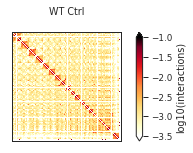

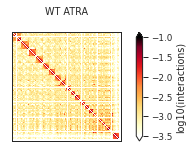

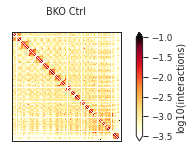

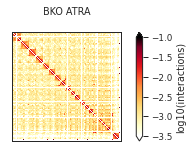

In [75]:
sns.set_style("ticks")
sns.set_context("paper")

for cond in ComboConds:
    
    binsize = 5000000

    opts = dict(
        vmin=-3.5, #change scale range here
        vmax=-1,
        cmap='fall'
    )

    fig = plt.figure(figsize=(2.5, 2))
    gs00 = GridSpec(nrows = 1, ncols = 2, width_ratios = [20] + [1], wspace=0.1)
    gs_cb = GridSpecFromSubplotSpec(nrows=1, ncols=1, wspace = 0.1, subplot_spec = gs00[1])

    #how many heatmaps
    gs0 = GridSpecFromSubplotSpec(nrows=1, ncols=1, wspace = 0.3, subplot_spec = gs00[0])
    gs1 = GridSpecFromSubplotSpec(nrows = 1, ncols = 1, wspace=0.1, hspace = 0.05, subplot_spec = gs0[0])

    c = clrs5Mb[cond]
    cis = c.matrix(balance = True)[0:, 0:]
    
    n,j = np.indices(cis.shape)
    n = n.flatten()
    j = j.flatten()
    # fill NaNs inside of the desired selection:
    nan_band_selector = (np.abs(n-j) < 2) #fills 2 bins on diagonal with nan
    cis[n[nan_band_selector],j[nan_band_selector]] = np.nan
    
    cisbins = c.bins()[0:]
    
    #plot heatmap
    ax = plt.subplot(gs1[0, 0])
    img = ax.matshow( 
        np.log10(cis),
        **opts)
    ax.axes.xaxis.set_visible(False)   
    ax.axes.yaxis.set_visible(False)

    ax.set_aspect('equal')
    plt.title(samplePlotNames[cond] + '\n')
    
    #color bar in it's own axis, and own gridspace
    colorAx = plt.subplot(gs_cb[0, 0])
    cb = plt.colorbar(img, cax = colorAx, extend = 'both')
    cb.set_label('log10(interactions)')
    #save separately for each condition
    plt.savefig(f"{outDataDir}/figures/220929_{cond}_CACollab_R1R2_AllbyAllHeatmaps_500MbBins_MinusDiag.png", dpi = 300, bbox_inches = 'tight')

In [76]:
#Difference heatmap

/tmp/ipykernel_946485/1487450481.py:28: RuntimeWarning: divide by zero encountered in log10
  treatLog10 = np.log10(treatcis)
/tmp/ipykernel_946485/1487450481.py:34: RuntimeWarning: divide by zero encountered in log10
  dmsoLog10 = np.log10(dmsocis)
/tmp/ipykernel_946485/1487450481.py:36: RuntimeWarning: invalid value encountered in subtract
  ratiocis = treatLog10-dmsoLog10
/tmp/ipykernel_946485/1487450481.py:28: RuntimeWarning: divide by zero encountered in log10
  treatLog10 = np.log10(treatcis)
/tmp/ipykernel_946485/1487450481.py:34: RuntimeWarning: divide by zero encountered in log10
  dmsoLog10 = np.log10(dmsocis)
/tmp/ipykernel_946485/1487450481.py:36: RuntimeWarning: invalid value encountered in subtract
  ratiocis = treatLog10-dmsoLog10
/tmp/ipykernel_946485/1487450481.py:28: RuntimeWarning: divide by zero encountered in log10
  treatLog10 = np.log10(treatcis)
/tmp/ipykernel_946485/1487450481.py:34: RuntimeWarning: divide by zero encountered in log10
  dmsoLog10 = np.log10(dms

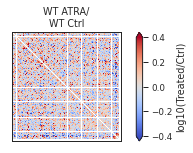

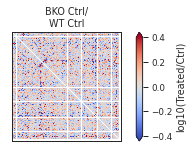

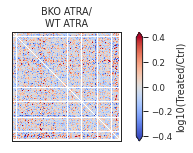

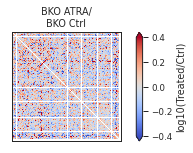

In [77]:
sns.set_style("ticks")
sns.set_context("paper")

#ratios for main figure - R1 + R2 combined only, 5Mb bins
binsize = 5000000

for DMSOcond, Treatcond in zip(ComboCtrlConds, ComboTreatConds):
    
    opts = dict(
       vmin=-0.4,
       vmax=0.4,
       cmap='coolwarm'
    )

    fig = plt.figure(figsize=(2.5, 2))

    gs00 = GridSpec(nrows = 1, ncols = 2, width_ratios = [20] + [1], wspace=0.1)

    gs_cb = GridSpecFromSubplotSpec(nrows=1, ncols=1, wspace = 0.1, subplot_spec = gs00[1])

    #how many heatmaps
    gs0 = GridSpecFromSubplotSpec(nrows=1, ncols=1, wspace = 0.3, subplot_spec = gs00[0])
    
    treatc = clrs5Mb[Treatcond]
    treatcis = treatc.matrix(balance = True)[0:, 0:]
    treatcisbins = treatc.bins()[0:]
    
    treatLog10 = np.log10(treatcis)
    
    dmsoc = clrs5Mb[DMSOcond]
    dmsocis = dmsoc.matrix(balance = True)[0:, 0:]
    dmsocisbins = dmsoc.bins()[0:]
    
    dmsoLog10 = np.log10(dmsocis)
    
    ratiocis = treatLog10-dmsoLog10
    k,j = np.indices(ratiocis.shape)
    k = k.flatten()
    j = j.flatten()
    # fill NaNs inside of the desired selection:
    nan_band_selector = (np.abs(k-j) < 2) #fills 2 bins on diagonal with nan
    ratiocis[k[nan_band_selector],j[nan_band_selector]] = np.nan
    
    ax = plt.subplot(gs0[0])
    img = ax.matshow(
        ratiocis, 
        **opts)
    ax.axes.xaxis.set_visible(False)   
    ax.axes.yaxis.set_visible(False)
    plt.title(samplePlotNames[Treatcond] + '/\n' + samplePlotNames[DMSOcond])
    ax.set_aspect('equal')
    
    # color bar in it's own axis, and own gridspace
    colorAx = plt.subplot(gs00[1])
    cb = plt.colorbar(img, cax = colorAx, extend = 'both')
    cb.set_label('log10(Treated/Ctrl)')

    plt.savefig(f"{outDataDir}/figures/220929_{Treatcond}vs{DMSOcond}_CACollab_R1R2_AllbyAll_minusdiag_Ratio_500KbBins.png", dpi = 300, bbox_inches = 'tight')

In [78]:
#chrom 1-5 only

/tmp/ipykernel_946485/2801993249.py:40: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),
/tmp/ipykernel_946485/2801993249.py:40: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),
/tmp/ipykernel_946485/2801993249.py:40: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),
/tmp/ipykernel_946485/2801993249.py:40: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),


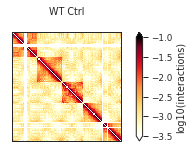

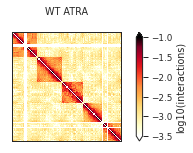

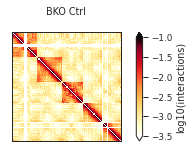

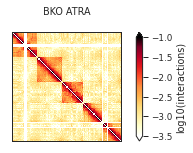

In [79]:
sns.set_style("ticks")
sns.set_context("paper")

binsize = 5000000

for cond in ComboConds:
    
    opts = dict(
        vmin=-3.5, #change scale range here
        vmax=-1,
        cmap='fall'
    )

    fig = plt.figure(figsize=(2.5, 2))

    gs00 = GridSpec(nrows = 1, ncols = 2, width_ratios = [20] + [1], wspace=0.1)

    gs_cb = GridSpecFromSubplotSpec(nrows=1, ncols=1, wspace = 0.1, subplot_spec = gs00[1])

    #how many heatmaps
    gs0 = GridSpecFromSubplotSpec(nrows=1, ncols=1, wspace = 0.3, subplot_spec = gs00[0])

    gs1 = GridSpecFromSubplotSpec(nrows = 1, ncols = 1, wspace=0.1, hspace = 0.05, subplot_spec = gs0[0])

    c = clrs5Mb[cond]
    cis = c.matrix(balance = True)[0:214, 0:214]
    
    n,j = np.indices(cis.shape)
    n = n.flatten()
    j = j.flatten()
    # fill NaNs inside of the desired selection:
    nan_band_selector = (np.abs(n-j) < 2) #fills 2 bins on diagonal with nan
    cis[n[nan_band_selector],j[nan_band_selector]] = np.nan
    
    cisbins = c.bins()[0:214]
    
    #plot heatmap
    ax = plt.subplot(gs1[0, 0])
    img = ax.matshow( #can change this to plt.imshow instead probably?
        np.log10(cis),
        **opts)
    ax.axes.xaxis.set_visible(False)   
    ax.axes.yaxis.set_visible(False)

    ax.set_aspect('equal')
    plt.title(samplePlotNames[cond] + '\n')
    
# color bar in it's own axis, and own gridspace
    colorAx = plt.subplot(gs_cb[0, 0])
    cb = plt.colorbar(img, cax = colorAx, extend = 'both')
    cb.set_label('log10(interactions)')

    #plt.suptitle(f'Chr14 Heatmaps and Eigen1 200kb Bins')
    plt.savefig(f"{outDataDir}/figures/220929_{cond}_CACollab_R1R2_chr1to5_heatmaps_500MbBins_MinusDiag.png", dpi = 300, bbox_inches = 'tight')

In [80]:
#Difference heatmap

/tmp/ipykernel_946485/460574480.py:29: RuntimeWarning: divide by zero encountered in log10
  treatLog10 = np.log10(treatcis)
/tmp/ipykernel_946485/460574480.py:35: RuntimeWarning: divide by zero encountered in log10
  dmsoLog10 = np.log10(dmsocis)
/tmp/ipykernel_946485/460574480.py:29: RuntimeWarning: divide by zero encountered in log10
  treatLog10 = np.log10(treatcis)
/tmp/ipykernel_946485/460574480.py:35: RuntimeWarning: divide by zero encountered in log10
  dmsoLog10 = np.log10(dmsocis)
/tmp/ipykernel_946485/460574480.py:29: RuntimeWarning: divide by zero encountered in log10
  treatLog10 = np.log10(treatcis)
/tmp/ipykernel_946485/460574480.py:35: RuntimeWarning: divide by zero encountered in log10
  dmsoLog10 = np.log10(dmsocis)
/tmp/ipykernel_946485/460574480.py:29: RuntimeWarning: divide by zero encountered in log10
  treatLog10 = np.log10(treatcis)
/tmp/ipykernel_946485/460574480.py:35: RuntimeWarning: divide by zero encountered in log10
  dmsoLog10 = np.log10(dmsocis)


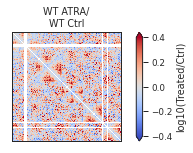

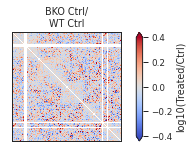

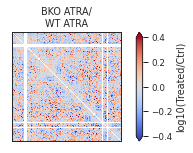

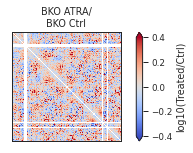

In [81]:
sns.set_style("ticks")
sns.set_context("paper")

#ratios for main figure - R1 + R2 combined only, 5Mb bins
binsize = 5000000

for DMSOcond, Treatcond in zip(ComboCtrlConds, ComboTreatConds):
    
    opts = dict(
       vmin=-0.4,
       vmax=0.4,
        cmap='coolwarm'
    )

    fig = plt.figure(figsize=(2.5, 2))

    gs00 = GridSpec(nrows = 1, ncols = 2, width_ratios = [20] + [1], wspace=0.1)

    gs_cb = GridSpecFromSubplotSpec(nrows=1, ncols=1, wspace = 0.1, subplot_spec = gs00[1])

    #how many heatmaps
    gs0 = GridSpecFromSubplotSpec(nrows=1, ncols=1, wspace = 0.3, subplot_spec = gs00[0])

    
    treatc = clrs5Mb[Treatcond]
    treatcis = treatc.matrix(balance = True)[0:214, 0:214]
    treatcisbins = treatc.bins()[0:214]
    
    treatLog10 = np.log10(treatcis)
    
    dmsoc = clrs5Mb[DMSOcond]
    dmsocis = dmsoc.matrix(balance = True)[0:214, 0:214]
    dmsocisbins = dmsoc.bins()[0:214]
    
    dmsoLog10 = np.log10(dmsocis)
    
    ratiocis = treatLog10-dmsoLog10
    k,j = np.indices(ratiocis.shape)
    k = k.flatten()
    j = j.flatten()
    # fill NaNs inside of the desired selection:
    nan_band_selector = (np.abs(k-j) < 2) #fills 2 bins on diagonal with nan
    ratiocis[k[nan_band_selector],j[nan_band_selector]] = np.nan
    
    ax = plt.subplot(gs0[0])
    img = ax.matshow(
        ratiocis, 
        **opts)
    ax.axes.xaxis.set_visible(False)   
    ax.axes.yaxis.set_visible(False)
    plt.title(samplePlotNames[Treatcond] + '/\n' + samplePlotNames[DMSOcond])
    ax.set_aspect('equal')
    
    # color bar in it's own axis, and own gridspace
    colorAx = plt.subplot(gs00[1])
    cb = plt.colorbar(img, cax = colorAx, extend = 'both')
    cb.set_label('log10(Treated/Ctrl)')

    plt.savefig(f"{outDataDir}/figures/220929_{Treatcond}vs{DMSOcond}_CACollab_R1R2_chr1to5_minusdiag_Ratio_500KbBins.png", dpi = 300, bbox_inches = 'tight')

In [82]:
#Heatmaps with eigenvectors - 250kb bins

In [83]:
#coolers - 250kb bins
binsize = 250000

clr_paths_250kb = {}
for cond in conditions:
    clr_paths_250kb[cond] = f'{outDataDir}/data/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'
    
clrs250kb = {
    cond: cooler.Cooler(clr_paths_250kb[cond]) for cond in conditions
}

In [84]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)
hg38_fullchroms = bioframe.make_viewframe(hg38_chromsizes)

In [85]:
good_chroms = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13',
              'chr14', 'chr16', 'chr18', 'chr19', 'chr20', 'chr21']

In [86]:
# Select only chromosomes that are present in the good chromosomes
hg38_chromsizes = hg38_chromsizes.loc[good_chroms]
hg38_arms = hg38_arms[hg38_arms.chrom.isin(good_chroms)].reset_index(drop=True)
hg38_fullchroms = hg38_fullchroms[hg38_fullchroms.chrom.isin(good_chroms)].reset_index(drop = True)

In [87]:
bins = cooler.binnify(hg38_chromsizes, binsize)

In [88]:
from bioframe.io.resources import UCSCClient
mrna = UCSCClient('hg38').fetch_mrna()

In [90]:
genecov = bioframe.frac_gene_coverage(bins, mrna) 

In [ ]:
#Get compartments, flip based on gene density, all chromosomes
#Not sorting by variance compared to gene density, instead by variance explained of data

lam = {}
eigs = {}

for cond in conditions:
    lam[cond], eigs[cond] = cooltools.eigs_cis(
        clrs250kb[cond], 
        genecov,
        n_eigs=3, 
        ignore_diags=2,
        view_df = hg38_fullchroms
    )

In [ ]:
for cond in conditions:
    # Save text files
    lam[cond].to_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.lam.txt', sep='\t')

In [ ]:
#plot eig1 for each region to make sure they were detecting compartments and not something else...
fig = plt.figure(figsize=(15, 2 * len(hg38_fullchroms)))

gs1 = GridSpec(nrows = len(hg38_fullchroms), ncols = 1, hspace = 0.8)

for i, chrom in enumerate(hg38_fullchroms.itertuples()):
    ax = plt.subplot(gs1[i])
    for cond in conditions:
        loc_eig = bioframe.select(eigs[cond], chrom[1:4])
        ax.plot(
            loc_eig['start'],
            loc_eig['E1'],
            label = cond,
            color = sampleColors[cond],
            ls = sampleLineStyles[cond]
        )
        plt.axhline(0,ls='--',lw=0.5,color='gray')
        plt.ylabel('E1')
        plt.xlabel('position, bp')
        plt.title(chrom)
        plt.legend()
        plt.ylim(-2, 2)

plt.savefig(f'{outDataDir}/figures/220911_CACollab_Eig1_250kb_bychrom_mapq30.png', dpi = 300)

In [ ]:
#Looks good except for chr18 and chr21 - need to flip Top2B KO for chr18 (all) and WT Ctrl R1 + R2, need to flip Top2BKO ATRA R1 and R1R2 for chr21.

for cond in ['WT_ATRA_R1', 'WT_ATRA_R2', 'WT_ATRA_R1R2', ]:
    eigs[cond].loc[eigs[cond]['chrom'] == 'chr18', 'E1'] = (eigs[cond].loc[eigs[cond]['chrom'] == 'chr18', 'E1'])*-1
    
for cond in ['Top2BKO_ATRA_R1', 'Top2BKO_ATRA_R1R2']:
    eigs[cond].loc[eigs[cond]['chrom'] == 'chr21', 'E1'] = (eigs[cond].loc[eigs[cond]['chrom'] == 'chr21', 'E1'])*-1

In [ ]:
#plot eig1 for each region to make sure they were detecting compartments and not something else...
fig = plt.figure(figsize=(15, 2 * len(hg38_fullchroms)))

gs1 = GridSpec(nrows = len(hg38_fullchroms), ncols = 1, hspace = 0.8)

for i, chrom in enumerate(hg38_fullchroms.itertuples()):
    ax = plt.subplot(gs1[i])
    for cond in conditions:
        loc_eig = bioframe.select(eigs[cond], chrom[1:4])
        ax.plot(
            loc_eig['start'],
            loc_eig['E1'],
            label = cond,
            color = sampleColors[cond],
            ls = sampleLineStyles[cond]
        )
        plt.axhline(0,ls='--',lw=0.5,color='gray')
        plt.ylabel('E1')
        plt.xlabel('position, bp')
        plt.title(chrom)
        plt.legend()
        plt.ylim(-2, 2)

plt.savefig(f'{outDataDir}/figures/220911_CACollab_Corrected_Eig1_250kb_bychrom_mapq30.png', dpi = 300)

In [ ]:
for cond in conditions:
    # Save text files
    eigs[cond].to_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.txt', sep='\t', index=False, na_rep = 'nan')
    
    # Save bedGraph track
    eigs[cond][['chrom', 'start', 'end', 'E1']].to_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.E1.bedGraph', sep='\t', index=False, na_rep = 'nan', header = False)
    # Save bigwig track
    bioframe.to_bigwig(eigs[cond], hg38_chromsizes, f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.E1.bw', 'E1')


In [91]:
#read in eigs
eigs = {}
for cond in conditions:
    eigs[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.txt', sep = '\t')

In [92]:
import cooltools.lib.plotting

/tmp/ipykernel_946485/2489084614.py:45: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),
/tmp/ipykernel_946485/2489084614.py:45: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),
/tmp/ipykernel_946485/2489084614.py:45: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),
/tmp/ipykernel_946485/2489084614.py:45: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),


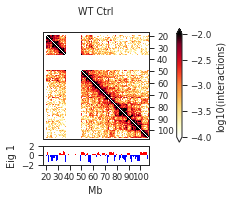

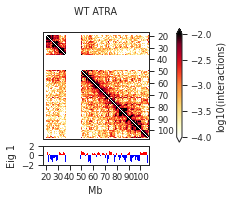

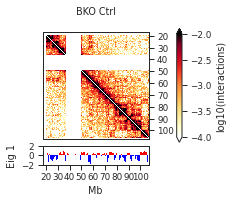

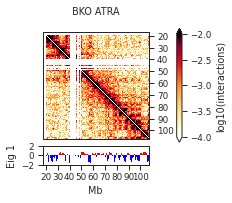

In [93]:
sns.set_context("paper")
sns.set_style('ticks')

for cond in ComboConds:
    
    plottingregion = 'chr14:17086761-107043718'
    chromarm = ('chr14', 17086761, 107043718)

    opts = dict(
        vmin=-4, #change scale range here
        vmax=-2,
        cmap='fall'
    )

    fig = plt.figure(figsize=(2.5, 2.5))

    gs00 = GridSpec(nrows = 1, ncols = 2, width_ratios = [20] + [1], wspace=0.5)

    gs_cb = GridSpecFromSubplotSpec(nrows=2, ncols=1, wspace = 0.1, subplot_spec = gs00[1], hspace = 0.05, 
                                    height_ratios = [6, 1])

    #how many heatmaps
    gs0 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec = gs00[0])
    
    gs1 = GridSpecFromSubplotSpec(nrows = 2, ncols = 1, height_ratios=[6, 1], wspace=0.1, 
                                  hspace = 0.05, subplot_spec = gs0[0])

    c = clrs250kb[cond]
    cis = c.matrix(balance = True).fetch(plottingregion)
    
    n,j = np.indices(cis.shape)
    n = n.flatten()
    j = j.flatten()
    # fill NaNs inside of the desired selection:
    nan_band_selector = (np.abs(n-j) < 2) #fills 2 bins on diagonal with nan
    cis[n[nan_band_selector],j[nan_band_selector]] = np.nan
    
    cisbins = c.bins().fetch(plottingregion)
    mids = cisbins['end'] - binsize/2
    mids = mids.reset_index(drop=True)
    
    #plot heatmap
    ax = plt.subplot(gs1[0, 0])
    img = ax.matshow( #can change this to plt.imshow instead probably?
        np.log10(cis), 
        extent=[
            mids[0]/1000000, 
            mids.iloc[-1]/1000000, 
            mids.iloc[-1]/1000000, 
            mids[0]/1000000], 
        **opts)
    ax.xaxis.set_visible(False)
    ax.yaxis.tick_right()    
    ax.set_aspect('equal')
    plt.title(samplePlotNames[cond] + '\n')
    
    # barplot of eigenvalues
    ax1 = plt.subplot(gs1[1, 0])
    plt.ylim(-2, 2) 
    plt.xlim(chromarm[1]/1000000, chromarm[2]/1000000)
    img2 = ax1.bar(
        x = list((eigs[cond][eigs[cond].chrom == chromarm[0]]['start'] + binsize/2)/1000000), 
        height = list(eigs[cond][eigs[cond].chrom == chromarm[0]]['E1']),
        width = 0.25,
        color=eigs[cond].E1[eigs[cond].chrom == chromarm[0]].apply(lambda x: 'r' if x>0 else 'b'),
        alpha = 1,
        linewidth = 0
                  )
    plt.ylabel('Eig 1')
    plt.xlabel('Mb')
    ax1.xaxis.set_ticks(np.arange(20, 110, 10)) #This specifically sets ticks to this range, to match y axis
    fig.add_subplot(ax1)
    
    # color bar in it's own axis, and own gridspace
    colorAx = plt.subplot(gs_cb[0, 0])
    cb = plt.colorbar(img, cax = colorAx, extend = 'both')
    cb.set_label('log10(interactions)')

    plt.savefig(f"{outDataDir}/figures/220929_{cond}_CACollab_R1R2Combined_FullChr14Heatmaps_250kbBins_MinusDiag_WithEigen1_Barplot_columns.png", dpi = 300, bbox_inches = 'tight')

In [94]:
#Difference heatmap

/tmp/ipykernel_946485/2613328357.py:31: RuntimeWarning: divide by zero encountered in log10
  treatLog10 = np.log10(treatcis)
/tmp/ipykernel_946485/2613328357.py:38: RuntimeWarning: divide by zero encountered in log10
  dmsoLog10 = np.log10(dmsocis)
/tmp/ipykernel_946485/2613328357.py:40: RuntimeWarning: invalid value encountered in subtract
  ratiocis = treatLog10-dmsoLog10
/tmp/ipykernel_946485/2613328357.py:31: RuntimeWarning: divide by zero encountered in log10
  treatLog10 = np.log10(treatcis)
/tmp/ipykernel_946485/2613328357.py:38: RuntimeWarning: divide by zero encountered in log10
  dmsoLog10 = np.log10(dmsocis)
/tmp/ipykernel_946485/2613328357.py:40: RuntimeWarning: invalid value encountered in subtract
  ratiocis = treatLog10-dmsoLog10
/tmp/ipykernel_946485/2613328357.py:31: RuntimeWarning: divide by zero encountered in log10
  treatLog10 = np.log10(treatcis)
/tmp/ipykernel_946485/2613328357.py:38: RuntimeWarning: divide by zero encountered in log10
  dmsoLog10 = np.log10(dms

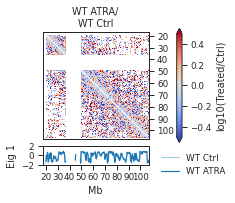

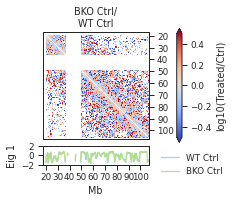

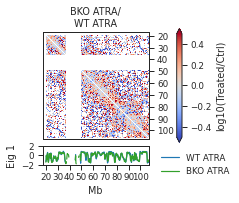

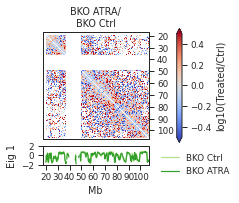

In [95]:
#ratios for main figure - R1 + R2 combined only, 250kb bins

for DMSOcond, Treatcond in zip(ComboCtrlConds, ComboTreatConds):
    
    plottingregion = 'chr14:17086761-107043718'
    chromarm = ('chr14', 17086761, 107043718)

    opts = dict(
        vmin=-.5,
        vmax=.5,
        cmap='coolwarm'
    )

    fig = plt.figure(figsize=(2.5, 2.5))

    gs00 = GridSpec(nrows = 1, ncols = 2, width_ratios = [20] + [1], wspace=0.5)

    gs_cb = GridSpecFromSubplotSpec(nrows=2, ncols=1, wspace = 0.1, subplot_spec = gs00[1], hspace = 0.05, 
                                    height_ratios = [6, 1])

    #how many heatmaps
    gs0 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec = gs00[0])
    gs1 = GridSpecFromSubplotSpec(nrows = 2, ncols = 1, height_ratios=[6, 1], wspace=0.1, 
                                  hspace = 0.05, subplot_spec = gs0[0])
    
    treatc = clrs250kb[Treatcond]
    treatcis = treatc.matrix(balance = True).fetch(plottingregion)
    treatcisbins = treatc.bins().fetch(plottingregion)
    treatmids = treatcisbins['end'] - binsize/2
    treatmids = treatmids.reset_index(drop=True)
    treatLog10 = np.log10(treatcis)
    
    dmsoc = clrs250kb[DMSOcond]
    dmsocis = dmsoc.matrix(balance = True).fetch(plottingregion)
    dmsocisbins = dmsoc.bins().fetch(plottingregion)
    dmsomids = dmsocisbins['end'] - binsize/2
    dmsomids = dmsomids.reset_index(drop=True)
    dmsoLog10 = np.log10(dmsocis)
    
    ratiocis = treatLog10-dmsoLog10
    k,j = np.indices(ratiocis.shape)
    k = k.flatten()
    j = j.flatten()
    # fill NaNs inside of the desired selection:
    nan_band_selector = (np.abs(k-j) < 2) #fills 2 bins on diagonal with nan
    ratiocis[k[nan_band_selector],j[nan_band_selector]] = np.nan
    
    ax = plt.subplot(gs1[0, 0])
    img = ax.matshow(
        ratiocis, extent=[treatmids[0]/1000000, treatmids.iloc[-1]/1000000, treatmids.iloc[-1]/1000000, treatmids[0]/1000000], 
        **opts)
    ax.axes.xaxis.set_visible(False)   
    ax.yaxis.tick_right() 
    plt.title(samplePlotNames[Treatcond] + '/\n' + samplePlotNames[DMSOcond])
    ax.set_aspect('equal')
    
    # barplot of eigenvalues - control and treatment - lineplots
    ax1 = plt.subplot(gs1[1, 0])
    plt.ylim(-2, 2) 
    plt.xlim(chromarm[1]/1000000, chromarm[2]/1000000)
    ax1.plot(
        list((eigs[DMSOcond][eigs[DMSOcond].chrom == chromarm[0]]['start'] + binsize/2)/1000000), 
        list(eigs[DMSOcond][eigs[DMSOcond].chrom == chromarm[0]]['E1']), color = sampleColors[DMSOcond], 
        label = samplePlotNames[DMSOcond])
    ax1.plot(
        list((eigs[Treatcond][eigs[Treatcond].chrom == chromarm[0]]['start'] + binsize/2)/1000000), 
        list(eigs[Treatcond][eigs[Treatcond].chrom == chromarm[0]]['E1']), color = sampleColors[Treatcond], 
        label = samplePlotNames[Treatcond])
    plt.ylabel('Eig 1')
    plt.xlabel('Mb')
    ax1.xaxis.set_ticks(np.arange(20, 110, 10)) #This specifically sets ticks to this range, to match y axis
    ax1.legend(bbox_to_anchor=(1.04,1), frameon = False)
    fig.add_subplot(ax1)
    
    # color bar in it's own axis, and own gridspace
    colorAx = plt.subplot(gs_cb[0])
    cb = plt.colorbar(img, cax = colorAx, extend = 'both')
    cb.set_label('log10(Treated/Ctrl)')

    plt.savefig(f"{outDataDir}/figures/220929_{Treatcond}vs{DMSOcond}_CACollab_R1R2Combined_Chr14DifferenceHeatmaps_minusdiag_250KbBins_LargerColorScale.png".format(outDataDir), dpi = 300, bbox_inches = 'tight')

In [96]:
#Saddleplots and strength with OWN eig1

In [97]:
#coolers - 250kb bins
binsize = 250000

clr_paths_250kb = {}
for cond in conditions:
    clr_paths_250kb[cond] = f'{outDataDir}/data/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'
    
clrs250kb = {
    cond: cooler.Cooler(clr_paths_250kb[cond]) for cond in conditions
}

In [98]:
#need to filter out arms without any data - from gfudenberg (https://github.com/open2c/cooltools/issues/330)
bins = clrs250kb['WT_Ctrl_R1'].bins()[:].copy()
bins['coverage'] = cooltools.coverage(clrs250kb['WT_Ctrl_R1'])[1]
bins

,chrom,start,end,weight,coverage
0,chr1,0,250000,NaN,22.0
1,chr1,250000,500000,NaN,4.0
2,chr1,500000,750000,NaN,15.0
3,chr1,750000,1000000,0.041628,1060.0
4,chr1,1000000,1250000,0.026020,1814.0
...,...,...,...,...,...
12362,chrY,56250000,56500000,NaN,0.0
12363,chrY,56500000,56750000,NaN,0.0
12364,chrY,56750000,57000000,0.782325,70.0
12365,chrY,57000000,57227415,NaN,0.0


In [99]:
view_coverage = bioframe.overlap(hg38_arms, bins).groupby('name').sum('coverage_')
view_coverage

,start,end,start_,end_,weight_,coverage_
name,,,,,,
chr10_p,0,6624336463,3300750000,3341500000,3.366633,316308.0
chr10_q,15199397774,50040235828,32584750000,32678047422,7.701862,785034.0
chr11_p,0,11183362732,5591500000,5644500000,4.457757,388823.0
chr11_q,17408064630,44578585260,30978750000,31061086622,7.026443,668690.0
chr12_p,0,5180735376,2574000000,2610000000,3.301614,262256.0
chr12_q,14067135639,52110645819,33039500000,33137025309,8.899199,749282.0
chr13_p,0,1174768056,586500000,603750000,0.000000,38.0
chr13_q,6639993360,44602087920,25593750000,25691114328,9.053460,742406.0
chr14_p,0,1178986509,586500000,603750000,0.000000,8.0


In [100]:
view_coverage['coverage_'].values > 1e4

array([ True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [101]:
hg38_arms_filtered = bioframe.make_viewframe(hg38_arms[hg38_arms['name'].isin(view_coverage[view_coverage['coverage_'].values > 1e4].index)])

In [102]:
hg38_arms_filtered

,chrom,start,end,name
0,chr1,0,123479591,chr1_p
1,chr1,123479591,248956422,chr1_q
2,chr2,0,93139351,chr2_p
3,chr2,93139351,242193529,chr2_q
4,chr3,0,92214016,chr3_p
5,chr3,92214016,198295559,chr3_q
6,chr4,0,50728006,chr4_p
7,chr4,50728006,190214555,chr4_q
8,chr5,0,48272853,chr5_p
9,chr5,48272853,181538259,chr5_q


In [103]:
hg38_arms_filtered.to_csv(f'{outDataDir}/data/hg38_arms_filtered.bed', index = False, header = None, sep = '\t')

In [105]:
for cond in conditions:
    in_fname = clr_paths_250kb[cond]
    region_fname = f'{outDataDir}/data/hg38_arms_filtered.bed'
    out_fname = f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv'
    !bsub -q short -W 01:00 -e /home/eh37w/lsf_jobs/LSB_%J.err -o /home/eh37w/lsf_jobs/LSB_%J.log \
        -n 4 -R span[hosts=1] -R select[ib] -R rusage[mem=4000] -R select[rh=8] -N -u erica.hildebrand@umassmed.edu \
        "cooltools expected-cis -p 4 -o $out_fname --clr-weight-name weight --ignore-diags 2 $in_fname --regions $region_fname"


In [106]:
#Saddle strength - AA, BB, AA + BB

In [107]:
#AA vs BB compartment scores
def saddle_strengthAB(S, C):
    """
    Parameters
    ----------
    S, C : 2D arrays, square, same shape
        Saddle sums and counts, respectively
        
    Returns
    -------
    2x1D array
    Ratios of cumulative corner interaction scores, where the saddle data is 
    separately AA/AB and BB/BA corners with increasing extent
    
    """
    m, n = S.shape
    if m != n:
        raise ValueError("`saddledata` should be square.")

    ratiosA = np.zeros(n)
    for k in range(1, n):
        intra_sumA = S[n-k:n, n-k:n].sum() 
        intra_countA = C[n-k:n, n-k:n].sum()
        intraA = intra_sumA / intra_countA
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosA[k] = intraA / inter
        
    ratiosB = np.zeros(n)
    for k in range(1, n):
        intra_sumB = S[0:k, 0:k].sum()
        intra_countB = C[0:k, 0:k].sum()
        intraB = intra_sumB / intra_countB
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosB[k] = intraB / inter
    
    ratios = {
        'A' : ratiosA,
        'B' : ratiosB
    }
    
    return ratios

In [108]:
# use this if expected already run, will be much faster
cis_exp = {}

for cond in conditions:
    cis_exp[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv', sep='\t')

In [109]:
cis_exp[cond] 

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
0,chr1_p,chr1_p,0,473,NaN,NaN,NaN,NaN
1,chr1_p,chr1_p,1,468,NaN,NaN,NaN,NaN
2,chr1_p,chr1_p,2,467,140486.0,29.883454,300.826552,0.063990
3,chr1_p,chr1_p,3,466,82763.0,17.808464,177.603004,0.038216
4,chr1_p,chr1_p,4,465,56792.0,12.153380,122.133333,0.026136
...,...,...,...,...,...,...,...,...
9173,chr21_q,chr21_q,135,0,0.0,0.000000,NaN,NaN
9174,chr21_q,chr21_q,136,0,0.0,0.000000,NaN,NaN
9175,chr21_q,chr21_q,137,0,0.0,0.000000,NaN,NaN
9176,chr21_q,chr21_q,138,0,0.0,0.000000,NaN,NaN


In [110]:
eigs = {}
for cond in conditions:
    eigs[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.txt', sep = '\t')


In [111]:
eigs[cond]

,chrom,start,end,weight,E1,E2,E3
0,chr1,0,250000,NaN,NaN,NaN,NaN
1,chr1,250000,500000,NaN,NaN,NaN,NaN
2,chr1,500000,750000,NaN,NaN,NaN,NaN
3,chr1,750000,1000000,0.022687,1.185084,0.816704,-0.124417
4,chr1,1000000,1250000,0.013938,1.504807,1.068178,0.144634
...,...,...,...,...,...,...,...
12362,chrY,56250000,56500000,NaN,NaN,NaN,NaN
12363,chrY,56500000,56750000,NaN,NaN,NaN,NaN
12364,chrY,56750000,57000000,0.213710,NaN,NaN,NaN
12365,chrY,57000000,57227415,NaN,NaN,NaN,NaN


In [112]:
#Saddle strength - all distances

In [46]:
#Use the function to return saddledata (just good chromosomes, by arm)

sums_ownE1 = {}
counts_ownE1 = {}

for cond in conditions:
    sums_ownE1[cond], counts_ownE1[cond] = cooltools.api.saddle.saddle(
            clr = clrs250kb[cond], 
            expected = cis_exp[cond], 
            contact_type = 'cis',
            view_df = hg38_arms_filtered.reset_index(drop = True),
            track = eigs[cond][['chrom', 'start', 'end', 'E1']],
            qrange = (0.02, 0.98),
            n_bins = 50,
            verbose = False
        )

/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/eh37w/bin/miniconda3/envs/open2c_cooler

In [47]:
#Compartment strength - AA vs BB

In [48]:
#Own Eig1

In [49]:
#AA vs BB strength
strengthAB_ownE1 = {}
for cond in conditions:
    strengthAB_ownE1[cond] = saddle_strengthAB(sums_ownE1[cond], counts_ownE1[cond])

In [50]:
SepTreatConds

['WT_ATRA_R1',
 'Top2BKO_Ctrl_R1',
 'Top2BKO_ATRA_R1',
 'Top2BKO_ATRA_R1',
 'WT_ATRA_R2',
 'Top2BKO_Ctrl_R2',
 'Top2BKO_ATRA_R2',
 'Top2BKO_ATRA_R2']

In [51]:
SepCtrlConds

['WT_Ctrl_R1',
 'WT_Ctrl_R1',
 'WT_ATRA_R1',
 'Top2BKO_Ctrl_R1',
 'WT_Ctrl_R2',
 'WT_Ctrl_R2',
 'WT_ATRA_R2',
 'Top2BKO_Ctrl_R2']

In [52]:
#log2 ratio of treatment/control saddle strength within each replicate
sep_log2_treatvsctrl = {}
for comp in ['A', 'B']:
    sep_log2_treatvsctrl[comp] = {}
    for treat, ctrl in zip(SepTreatConds, SepCtrlConds):
        sep_log2_treatvsctrl[comp][f'{treat}vs{ctrl}'] = np.log2(strengthAB_ownE1[treat][comp]) - np.log2(strengthAB_ownE1[ctrl][comp])
        

/tmp/ipykernel_3202445/509225842.py:6: RuntimeWarning: divide by zero encountered in log2
  sep_log2_treatvsctrl[comp][f'{treat}vs{ctrl}'] = np.log2(strengthAB_ownE1[treat][comp]) - np.log2(strengthAB_ownE1[ctrl][comp])
/tmp/ipykernel_3202445/509225842.py:6: RuntimeWarning: invalid value encountered in subtract
  sep_log2_treatvsctrl[comp][f'{treat}vs{ctrl}'] = np.log2(strengthAB_ownE1[treat][comp]) - np.log2(strengthAB_ownE1[ctrl][comp])


In [113]:
#Plot bargraph of avg and dots of replicates log2(treat/ctrl) for AA and BB comp strength
#10 bin square - top 20% A or B

comp_score_df = pd.DataFrame(columns = ['Comparison', 'Compartment', 'Replicate', 'Label', 'Score'])

repdict = {
    'WT_Ctrl_R1' : 'R1',
    'Top2BKO_Ctrl_R1' : 'R1',
    'WT_ATRA_R1' : 'R1',
    'Top2BKO_ATRA_R1' : 'R1',    
    'WT_Ctrl_R2' : 'R2',
    'Top2BKO_Ctrl_R2' : 'R2',
    'WT_ATRA_R2' : 'R2',
    'Top2BKO_ATRA_R2' : 'R2',
}

labeldict = {
    'WT_Ctrl_R1' : 'WT Ctrl',
    'Top2BKO_Ctrl_R1' : 'BKO Ctrl',
    'WT_ATRA_R1' : 'WT ATRA',
    'Top2BKO_ATRA_R1' : 'BKO ATRA',
    'WT_Ctrl_R2' : 'WT Ctrl',
    'Top2BKO_Ctrl_R2' : 'BKO Ctrl',
    'WT_ATRA_R2' : 'WT ATRA',
    'Top2BKO_ATRA_R2' : 'BKO ATRA',
}

labelPlotColors = {
    'WT Ctrl' : '#17BECF',
    'BKO Ctrl' : '#D62728',
    'WT ATRA' : '#574D68',
    'BKO ATRA' : '#C6A15B',
}

In [54]:
#Plot actual comp strength (not vs control), cis

In [55]:
comp_score_df_cis = pd.DataFrame(columns = ['Condition', 'Compartment', 'Replicate', 'Label', 'Score'])

for cond in conditions[0:8]:
    for comp in ['A', 'B']:
            comp_score_df_cis = comp_score_df_cis.append({
                'Condition' : cond, 
                'Compartment' : comp, 
                'Replicate' : repdict[cond], 
                'Label' : labeldict[cond],
                'Score' : strengthAB_ownE1[cond][comp][9]
            }, ignore_index = True)


/tmp/ipykernel_3202445/4142384691.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis = comp_score_df_cis.append({
/tmp/ipykernel_3202445/4142384691.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis = comp_score_df_cis.append({
/tmp/ipykernel_3202445/4142384691.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis = comp_score_df_cis.append({
/tmp/ipykernel_3202445/4142384691.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis = comp_score_df_cis.append({
/tmp/ipykernel_3202445/4142384691.py:5: FutureWarning: The frame.append method is deprecated and will be removed

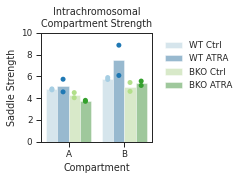

In [56]:
#https://stackoverflow.com/questions/64223870/seaborn-overlap-swarmplot-on-barplot
sns.set_style("ticks")
sns.set_context("paper")
cmap_bar = sns.color_palette(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c'])
gs = GridSpec(nrows= 1, ncols=1, wspace = 0.6, hspace = 0.6)

plt.figure(figsize=(2, 2))

ax = plt.subplot(gs[0])

sns.stripplot(x='Compartment', 
                  y='Score', 
                  hue='Label', 
                  dodge=True, 
                  data=comp_score_df_cis, 
                  jitter = False, 
                  palette = cmap_bar, 
                  ax = ax)
ax1 = sns.barplot(x='Compartment', 
                      y='Score', 
                      hue='Label', 
                      data=comp_score_df_cis, 
                      palette = cmap_bar, 
                      alpha = 0.5, 
                      ci = False, 
                      ax = ax)
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[4:8], labels[4:8], bbox_to_anchor=(1.04,1), frameon = False)
 
plt.title(f'Intrachromosomal\nCompartment Strength')
plt.ylabel('Saddle Strength')  
plt.ylim(0, 10)
plt.xlabel('Compartment')
        
plt.savefig(f'{outDataDir}/figures/220929_CACollab_R1R2_HiC_compstrength_notvsctrl_Eig1.png', dpi = 300, bbox_inches = "tight")

In [60]:
#Saddleplots and strength with OWN eig1 - different distances

In [121]:
#Saddle strength - AA, BB, AA + BB

In [122]:
#AA vs BB compartment scores
def saddle_strengthAB(S, C):
    """
    Parameters
    ----------
    S, C : 2D arrays, square, same shape
        Saddle sums and counts, respectively
        
    Returns
    -------
    2x1D array
    Ratios of cumulative corner interaction scores, where the saddle data is 
    separately AA/AB and BB/BA corners with increasing extent
    
    """
    m, n = S.shape
    if m != n:
        raise ValueError("`saddledata` should be square.")

    ratiosA = np.zeros(n)
    for k in range(1, n):
        intra_sumA = S[n-k:n, n-k:n].sum() 
        intra_countA = C[n-k:n, n-k:n].sum()
        intraA = intra_sumA / intra_countA
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosA[k] = intraA / inter
        
    ratiosB = np.zeros(n)
    for k in range(1, n):
        intra_sumB = S[0:k, 0:k].sum()
        intra_countB = C[0:k, 0:k].sum()
        intraB = intra_sumB / intra_countB
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosB[k] = intraB / inter
    
    ratios = {
        'A' : ratiosA,
        'B' : ratiosB
    }
    
    return ratios

In [123]:
# use this if expected already run, will be much faster
cis_exp = {}

for cond in conditions:
    cis_exp[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv', sep='\t')

In [124]:
cis_exp[cond] 

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
0,chr1_p,chr1_p,0,473,NaN,NaN,NaN,NaN
1,chr1_p,chr1_p,1,468,NaN,NaN,NaN,NaN
2,chr1_p,chr1_p,2,467,140486.0,29.883454,300.826552,0.063990
3,chr1_p,chr1_p,3,466,82763.0,17.808464,177.603004,0.038216
4,chr1_p,chr1_p,4,465,56792.0,12.153380,122.133333,0.026136
...,...,...,...,...,...,...,...,...
9173,chr21_q,chr21_q,135,0,0.0,0.000000,NaN,NaN
9174,chr21_q,chr21_q,136,0,0.0,0.000000,NaN,NaN
9175,chr21_q,chr21_q,137,0,0.0,0.000000,NaN,NaN
9176,chr21_q,chr21_q,138,0,0.0,0.000000,NaN,NaN


In [125]:
eigs = {}
for cond in conditions:
    eigs[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.txt', sep = '\t')


In [126]:
eigs[cond]

,chrom,start,end,weight,E1,E2,E3
0,chr1,0,250000,NaN,NaN,NaN,NaN
1,chr1,250000,500000,NaN,NaN,NaN,NaN
2,chr1,500000,750000,NaN,NaN,NaN,NaN
3,chr1,750000,1000000,0.022687,1.185084,0.816704,-0.124417
4,chr1,1000000,1250000,0.013938,1.504807,1.068178,0.144634
...,...,...,...,...,...,...,...
12362,chrY,56250000,56500000,NaN,NaN,NaN,NaN
12363,chrY,56500000,56750000,NaN,NaN,NaN,NaN
12364,chrY,56750000,57000000,0.213710,NaN,NaN,NaN
12365,chrY,57000000,57227415,NaN,NaN,NaN,NaN


In [127]:
#Saddle strength by distance

In [128]:
#make bands - changed distances to be doubling for each bin

#make bands
binsize=250000

bandedges = np.array([0, 2500000, 5000000, 10000000, 20000000, 40000000, 80000000])
bands = list(zip(bandedges[:-1],bandedges[1:]))
print('bands in bp')
for band in bands:
    print(band)
bands = list(zip((bandedges[:-1]/binsize).astype(int), \
                 (bandedges[1:]/binsize).astype(int)))
print('bands in bins')
new_bands = []
for band in bands:
    if band[0] == 0:
        new_bands.append((3, band[1]))
    else:
        new_bands.append((band[0] + 1, band[1]))
        
for band in new_bands:
    print(band)
    
bands = new_bands

bands in bp
(0, 2500000)
(2500000, 5000000)
(5000000, 10000000)
(10000000, 20000000)
(20000000, 40000000)
(40000000, 80000000)
bands in bins
(3, 10)
(11, 20)
(21, 40)
(41, 80)
(81, 160)
(161, 320)


In [129]:
bands

[(3, 10), (11, 20), (21, 40), (41, 80), (81, 160), (161, 320)]

In [130]:
#Strength by band for own eig1

In [131]:
#Use the function to return saddledata for each band size (just good chromosomes, by arm)

sumsBands_ownE1 = {}
countsBands_ownE1 = {}

for cond in conditions:
    sumsBands_ownE1[cond] = {}
    countsBands_ownE1[cond] = {}
    for band in bands:
        sumsBands_ownE1[cond][band], countsBands_ownE1[cond][band] = cooltools.api.saddle.saddle(
            clr = clrs250kb[cond], 
            expected = cis_exp[cond], 
            contact_type = 'cis',
            view_df = hg38_arms_filtered.reset_index(drop = True), #why is this needed? doesn't work without resetting index?
            min_diag = band[0],
            max_diag = band[1],
            track = eigs[cond][['chrom', 'start', 'end', 'E1']],
            qrange = (0.02, 0.98),
            n_bins = 50,
            verbose = False
        )

/home/erica.hildebrand-umw/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/erica.hildebrand-umw/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/erica.hildebrand-umw/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/erica.hildebrand-umw/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/erica.hildebrand-umw/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/erica.hildebrand-umw/minicond

/home/erica.hildebrand-umw/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/erica.hildebrand-umw/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/erica.hildebrand-umw/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/erica.hildebrand-umw/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/erica.hildebrand-umw/miniconda3/envs/cooltools/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/erica.hildebrand-umw/minicond

In [132]:
#Compartment strength - AA vs BB, by distance band

In [133]:
#Own Eig1

In [134]:
#AA vs BB strength
strengthABBands_ownE1 = {}
for cond in conditions:
    strengthABBands_ownE1[cond] = {}
    for band in bands:
        strengthABBands_ownE1[cond][band] = saddle_strengthAB(sumsBands_ownE1[cond][band], countsBands_ownE1[cond][band])

/tmp/ipykernel_946485/2166326075.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  ratiosA[k] = intraA / inter
/tmp/ipykernel_946485/2166326075.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  ratiosB[k] = intraB / inter


In [135]:
SepTreatConds

['WT_ATRA_R1',
 'Top2BKO_Ctrl_R1',
 'Top2BKO_ATRA_R1',
 'Top2BKO_ATRA_R1',
 'WT_ATRA_R2',
 'Top2BKO_Ctrl_R2',
 'Top2BKO_ATRA_R2',
 'Top2BKO_ATRA_R2']

In [136]:
SepCtrlConds

['WT_Ctrl_R1',
 'WT_Ctrl_R1',
 'WT_ATRA_R1',
 'Top2BKO_Ctrl_R1',
 'WT_Ctrl_R2',
 'WT_Ctrl_R2',
 'WT_ATRA_R2',
 'Top2BKO_Ctrl_R2']

In [137]:
#log2 ratio of treatment/control saddle strength within each replicate
sep_log2_treatvsctrl_bands = {}
for comp in ['A', 'B']:
    sep_log2_treatvsctrl_bands[comp] = {}
    for treat, ctrl in zip(SepTreatConds, SepCtrlConds):
        sep_log2_treatvsctrl_bands[comp][f'{treat}vs{ctrl}'] = {}
        for band in bands:
            sep_log2_treatvsctrl_bands[comp][f'{treat}vs{ctrl}'][band] = np.log2(strengthABBands_ownE1[treat][band][comp]) - np.log2(strengthABBands_ownE1[ctrl][band][comp])
        

/tmp/ipykernel_946485/3223837063.py:8: RuntimeWarning: divide by zero encountered in log2
  sep_log2_treatvsctrl_bands[comp][f'{treat}vs{ctrl}'][band] = np.log2(strengthABBands_ownE1[treat][band][comp]) - np.log2(strengthABBands_ownE1[ctrl][band][comp])
/tmp/ipykernel_946485/3223837063.py:8: RuntimeWarning: invalid value encountered in subtract
  sep_log2_treatvsctrl_bands[comp][f'{treat}vs{ctrl}'][band] = np.log2(strengthABBands_ownE1[treat][band][comp]) - np.log2(strengthABBands_ownE1[ctrl][band][comp])


In [138]:
#Plot bargraph of avg and dots of replicates log2(treat/ctrl) for AA and BB comp strength by band
#10 bin square - top 20% A or B

comp_score_df = pd.DataFrame(columns = ['Comparison', 'Compartment', 'Replicate', 'Label', 'Score'])

repdict = {
    'WT_Ctrl_R1' : 'R1',
    'Top2BKO_Ctrl_R1' : 'R1',
    'WT_ATRA_R1' : 'R1',
    'Top2BKO_ATRA_R1' : 'R1',    
    'WT_Ctrl_R2' : 'R2',
    'Top2BKO_Ctrl_R2' : 'R2',
    'WT_ATRA_R2' : 'R2',
    'Top2BKO_ATRA_R2' : 'R2',
}

labeldict = {
    'WT_Ctrl_R1' : 'WT Ctrl',
    'Top2BKO_Ctrl_R1' : 'Top2BKO Ctrl',
    'WT_ATRA_R1' : 'WT ATRA',
    'Top2BKO_ATRA_R1' : 'Top2BKO ATRA',
    'WT_Ctrl_R2' : 'WT Ctrl',
    'Top2BKO_Ctrl_R2' : 'Top2BKO Ctrl',
    'WT_ATRA_R2' : 'WT ATRA',
    'Top2BKO_ATRA_R2' : 'Top2BKO ATRA',
}

labelPlotColors = {
    'WT Ctrl' : '#17BECF',
    'BKO Ctrl' : '#D62728',
    'WT ATRA' : '#574D68',
    'BKO ATRA' : '#C6A15B',
}

In [139]:
#Plot bargraph of avg and dots of replicates log2(treat/ctrl) for AA and BB comp strength by band
#10 bin square - top 20% A or B

comp_score_df = pd.DataFrame(columns = ['Comparison', 'Compartment', 'Replicate', 'Label', 'Score'])

for treat, ctrl in zip(SepTreatConds, SepCtrlConds):
    for comp in ['A', 'B']:
        for band in bands:
            comp_score_df = comp_score_df.append({
                'Comparison' : f'{treat}vs{ctrl}', 
                'Distance' : band,
                'Distance_Mb' : f'{[(binsize*x)/1e6 for x in band][0]}-{[(binsize*x)/1e6 for x in band][1]}',
                'Compartment' : comp, 
                'Replicate' : repdict[treat], 
                'Label' : f'{labeldict[treat]}/{labeldict[ctrl]}',
                'Score' : sep_log2_treatvsctrl_bands[comp][f'{treat}vs{ctrl}'][band][9]
            }, ignore_index = True)
    

/tmp/ipykernel_946485/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df = comp_score_df.append({
/tmp/ipykernel_946485/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df = comp_score_df.append({
/tmp/ipykernel_946485/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df = comp_score_df.append({
/tmp/ipykernel_946485/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df = comp_score_df.append({
/tmp/ipykernel_946485/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

/tmp/ipykernel_946485/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df = comp_score_df.append({
/tmp/ipykernel_946485/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df = comp_score_df.append({
/tmp/ipykernel_946485/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df = comp_score_df.append({
/tmp/ipykernel_946485/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df = comp_score_df.append({
/tmp/ipykernel_946485/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

In [140]:
comp_score_df

,Comparison,Compartment,Replicate,Label,Score,Distance,Distance_Mb
0,WT_ATRA_R1vsWT_Ctrl_R1,A,R1,WT ATRA/WT Ctrl,0.187607,"(3, 10)",0.75-2.5
1,WT_ATRA_R1vsWT_Ctrl_R1,A,R1,WT ATRA/WT Ctrl,0.21429,"(11, 20)",2.75-5.0
2,WT_ATRA_R1vsWT_Ctrl_R1,A,R1,WT ATRA/WT Ctrl,0.146072,"(21, 40)",5.25-10.0
3,WT_ATRA_R1vsWT_Ctrl_R1,A,R1,WT ATRA/WT Ctrl,-0.02149,"(41, 80)",10.25-20.0
4,WT_ATRA_R1vsWT_Ctrl_R1,A,R1,WT ATRA/WT Ctrl,-0.134981,"(81, 160)",20.25-40.0
...,...,...,...,...,...,...,...
91,Top2BKO_ATRA_R2vsTop2BKO_Ctrl_R2,B,R2,Top2BKO ATRA/Top2BKO Ctrl,0.070704,"(11, 20)",2.75-5.0
92,Top2BKO_ATRA_R2vsTop2BKO_Ctrl_R2,B,R2,Top2BKO ATRA/Top2BKO Ctrl,0.223723,"(21, 40)",5.25-10.0
93,Top2BKO_ATRA_R2vsTop2BKO_Ctrl_R2,B,R2,Top2BKO ATRA/Top2BKO Ctrl,0.169056,"(41, 80)",10.25-20.0
94,Top2BKO_ATRA_R2vsTop2BKO_Ctrl_R2,B,R2,Top2BKO ATRA/Top2BKO Ctrl,0.081905,"(81, 160)",20.25-40.0


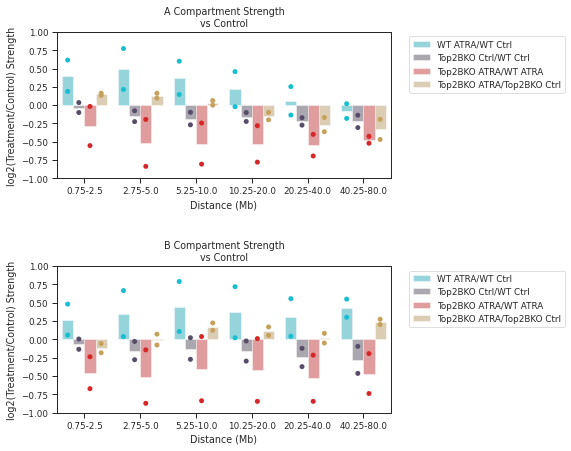

In [144]:
#https://stackoverflow.com/questions/64223870/seaborn-overlap-swarmplot-on-barplot
cmap_bar = sns.color_palette(['#17BECF', '#574D68','#D62728', '#C6A15B'])
gs = GridSpec(nrows= 2, ncols=1, wspace = 0.6, hspace = 0.6)

plt.figure(figsize=(6, 7))

for i, comp in enumerate(['A', 'B']):
    ax = plt.subplot(gs[i])

    sns.stripplot(x='Distance_Mb', 
                  y='Score', 
                  hue='Label', 
                  dodge=True, 
                  data=comp_score_df.loc[comp_score_df['Compartment'] == comp, :], 
                  jitter = False, 
                  palette = cmap_bar, 
                  ax = ax)
    ax1 = sns.barplot(x='Distance_Mb', 
                      y='Score', 
                      hue='Label', 
                      data=comp_score_df.loc[comp_score_df['Compartment'] == comp, :], 
                      palette = cmap_bar, 
                      alpha = 0.5, 
                      ci = False, 
                      ax = ax)
    
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[4:8], labels[4:8], bbox_to_anchor=(1.04,1))
 
    plt.title(f'{comp} Compartment Strength\nvs Control')
    plt.ylabel('log2(Treatment/Control) Strength')  
    plt.ylim(-1, 1)
    plt.xlabel('Distance (Mb)')
        
plt.savefig(f'{outDataDir}/figures/250120_CACollab_R1R2_HiC_CompStrengthByDistance_BarWithScatter_250kbbinEig1.png', dpi = 300, bbox_inches = "tight")

In [145]:
#Long-range A compartment strenth particularly affected by Top2BKO + ATRA compared to WT ATRA or Top2BKO control

In [146]:
#Plot actual comp strength (not vs control), cis

In [147]:
comp_score_df_cis_2 = pd.DataFrame(columns = ['Condition', 'Compartment', 'Replicate', 'Label', 'Score'])

for cond in conditions[0:8]:
    for comp in ['A', 'B']:
        for band in bands:
            comp_score_df_cis_2 = comp_score_df_cis_2.append({
                'Condition' : cond, 
                'Compartment' : comp, 
                'Replicate' : repdict[cond], 
                'Label' : labeldict[cond],
                'Distance' : band,
                'Distance_Mb' : f'{[(binsize*x)/1e6 for x in band][0]}-{[(binsize*x)/1e6 for x in band][1]}',
                'Score' : strengthABBands_ownE1[cond][band][comp][9]
            }, ignore_index = True)


/tmp/ipykernel_946485/2936879661.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis_2 = comp_score_df_cis_2.append({
/tmp/ipykernel_946485/2936879661.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis_2 = comp_score_df_cis_2.append({
/tmp/ipykernel_946485/2936879661.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis_2 = comp_score_df_cis_2.append({
/tmp/ipykernel_946485/2936879661.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis_2 = comp_score_df_cis_2.append({
/tmp/ipykernel_946485/2936879661.py:6: FutureWarning: The frame.append method is deprecated and will

/tmp/ipykernel_946485/2936879661.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis_2 = comp_score_df_cis_2.append({
/tmp/ipykernel_946485/2936879661.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis_2 = comp_score_df_cis_2.append({
/tmp/ipykernel_946485/2936879661.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis_2 = comp_score_df_cis_2.append({
/tmp/ipykernel_946485/2936879661.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis_2 = comp_score_df_cis_2.append({
/tmp/ipykernel_946485/2936879661.py:6: FutureWarning: The frame.append method is deprecated and will

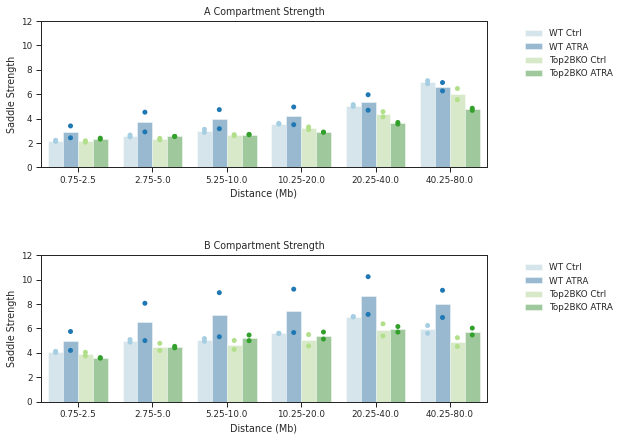

In [157]:
#https://stackoverflow.com/questions/64223870/seaborn-overlap-swarmplot-on-barplot
cmap_bar = sns.color_palette(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c'])
gs = GridSpec(nrows= 2, ncols=1, wspace = 0.6, hspace = 0.6)

plt.figure(figsize=(8, 7))

for i, comp in enumerate(['A', 'B']):
    ax = plt.subplot(gs[i])

    sns.stripplot(x='Distance_Mb', 
                  y='Score', 
                  hue='Label', 
                  dodge=True, 
                  data=comp_score_df_cis_2.loc[comp_score_df_cis_2['Compartment'] == comp, :], 
                  jitter = False, 
                  palette = cmap_bar, 
                  ax = ax)
    ax1 = sns.barplot(x='Distance_Mb', 
                      y='Score', 
                      hue='Label', 
                      data=comp_score_df_cis_2.loc[comp_score_df_cis_2['Compartment'] == comp, :], 
                      palette = cmap_bar, 
                      alpha = 0.5, 
                      ci = False, 
                      ax = ax)
    
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[4:8], labels[4:8], bbox_to_anchor=(1.3,1), frameon = False)
 
    plt.title(f'{comp} Compartment Strength')
    plt.ylabel('Saddle Strength')  
    plt.ylim(0, 12)
    plt.xlabel('Distance (Mb)')
        
plt.savefig(f'{outDataDir}/figures/250120_CACollab_R1R2_HiC_compstrength_notvsctrl_Eig1.png', dpi = 300, bbox_inches = "tight"
           )

In [57]:
#Compartment strength analysis - use own eigens, calculate separately for reach replicate, trans saddle

In [58]:
# create pairwise combinations of chromosomes for calculating average interactions:
regions = bioframe.core.construction.add_ucsc_name_column(bioframe.from_any(hg38_chromsizes))
region_pairs = list(combinations(regions[['chrom', 'start', 'end']].values, 2))

In [59]:
region_pairs

[(array(['chr1', 0, 248956422], dtype=object),
  array(['chr2', 0, 242193529], dtype=object)),
 (array(['chr1', 0, 248956422], dtype=object),
  array(['chr3', 0, 198295559], dtype=object)),
 (array(['chr1', 0, 248956422], dtype=object),
  array(['chr4', 0, 190214555], dtype=object)),
 (array(['chr1', 0, 248956422], dtype=object),
  array(['chr5', 0, 181538259], dtype=object)),
 (array(['chr1', 0, 248956422], dtype=object),
  array(['chr6', 0, 170805979], dtype=object)),
 (array(['chr1', 0, 248956422], dtype=object),
  array(['chr9', 0, 138394717], dtype=object)),
 (array(['chr1', 0, 248956422], dtype=object),
  array(['chr10', 0, 133797422], dtype=object)),
 (array(['chr1', 0, 248956422], dtype=object),
  array(['chr11', 0, 135086622], dtype=object)),
 (array(['chr1', 0, 248956422], dtype=object),
  array(['chr12', 0, 133275309], dtype=object)),
 (array(['chr1', 0, 248956422], dtype=object),
  array(['chr13', 0, 114364328], dtype=object)),
 (array(['chr1', 0, 248956422], dtype=object),

In [60]:
regions.to_csv(f'{outDataDir}/data/hg38_chroms.bed', index = False, sep = '\t', header = None)

In [57]:
for cond in conditions:
    in_fname = clr_paths_250kb[cond]
    region_fname = f'{outDataDir}/data/hg38_chroms.bed'
    out_fname = f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.trans.cli.tsv'
    !bsub -q short -W 01:00 -e /home/eh37w/lsf_jobs/LSB_%J.err -o /home/eh37w/lsf_jobs/LSB_%J.log \
        -n 4 -R span[hosts=1] -R select[ib] -R rusage[mem=4000] -R select[rh=8] -N -u erica.hildebrand@umassmed.edu \
        "cooltools expected-trans -p 4 -o $out_fname $in_fname --view $region_fname"


Job <9985880> is submitted to queue <short>.
Job <9985881> is submitted to queue <short>.
Job <9985882> is submitted to queue <short>.
Job <9985883> is submitted to queue <short>.
Job <9985884> is submitted to queue <short>.
Job <9985885> is submitted to queue <short>.
Job <9985886> is submitted to queue <short>.
Job <9985887> is submitted to queue <short>.
Job <9985888> is submitted to queue <short>.
Job <9985889> is submitted to queue <short>.
Job <9985890> is submitted to queue <short>.
Job <9985891> is submitted to queue <short>.


In [61]:
#Saddle strength - AA, BB, AA + BB

In [62]:
# use this if expected already run, will be much faster
trans_exp = {}

for cond in conditions:
    trans_exp[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.trans.cli.tsv', sep='\t')

In [63]:
trans_exp[cond]

,region1,region2,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
0,chr1:0-248956422,chr2:0-242193529,815556,83969.0,16.809238,0.102959,0.000021
1,chr1:0-248956422,chr3:0-198295559,682404,72382.0,14.872069,0.106069,0.000022
2,chr1:0-248956422,chr4:0-190214555,653496,61926.0,13.966434,0.094761,0.000021
3,chr1:0-248956422,chr5:0-181538259,609696,62391.0,13.024050,0.102331,0.000021
4,chr1:0-248956422,chr6:0-170805979,583416,63085.0,13.035739,0.108130,0.000022
...,...,...,...,...,...,...,...
131,chr18:0-80373285,chr20:0-64444167,69090,15723.0,3.286854,0.227573,0.000048
132,chr18:0-80373285,chr21:0-46709983,38514,10088.0,2.530430,0.261931,0.000066
133,chr19:0-58617616,chr20:0-64444167,50760,19889.0,3.609396,0.391824,0.000071
134,chr19:0-58617616,chr21:0-46709983,28296,9659.0,2.070033,0.341356,0.000073


In [64]:
regions

,chrom,start,end,name
0,chr1,0,248956422,chr1:0-248956422
1,chr2,0,242193529,chr2:0-242193529
2,chr3,0,198295559,chr3:0-198295559
3,chr4,0,190214555,chr4:0-190214555
4,chr5,0,181538259,chr5:0-181538259
5,chr6,0,170805979,chr6:0-170805979
6,chr9,0,138394717,chr9:0-138394717
7,chr10,0,133797422,chr10:0-133797422
8,chr11,0,135086622,chr11:0-135086622
9,chr12,0,133275309,chr12:0-133275309


In [65]:
#Use the function to return saddledata for each band size (just good chromosomes, by arm)

trans_sums = {}
trans_counts = {}

for cond in conditions:
    trans_sums[cond], trans_counts[cond] = cooltools.api.saddle.saddle(
        clr = clrs250kb[cond], 
        expected = trans_exp[cond], 
        contact_type = 'trans',
        view_df = regions,
        track = eigs[cond][['chrom', 'start', 'end', 'E1']],
        qrange = (0.02, 0.98),
        n_bins = 50,
        verbose = False
        )

In [66]:
#Compartment strength - AA vs BB, in trans

In [67]:
#AA vs BB compartment scores
def saddle_strengthAB(S, C):
    """
    Parameters
    ----------
    S, C : 2D arrays, square, same shape
        Saddle sums and counts, respectively
        
    Returns
    -------
    2x1D array
    Ratios of cumulative corner interaction scores, where the saddle data is 
    separately AA/AB and BB/BA corners with increasing extent
    
    """
    m, n = S.shape
    if m != n:
        raise ValueError("`saddledata` should be square.")

    ratiosA = np.zeros(n)
    for k in range(1, n):
        intra_sumA = S[n-k:n, n-k:n].sum() 
        intra_countA = C[n-k:n, n-k:n].sum()
        intraA = intra_sumA / intra_countA
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosA[k] = intraA / inter
        
    ratiosB = np.zeros(n)
    for k in range(1, n):
        intra_sumB = S[0:k, 0:k].sum()
        intra_countB = C[0:k, 0:k].sum()
        intraB = intra_sumB / intra_countB
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosB[k] = intraB / inter
    
    ratios = {
        'A' : ratiosA,
        'B' : ratiosB
    }
    
    return ratios

In [68]:
#Own Eig1

In [69]:
#AA vs BB strength, trans
strengthABTrans_ownE1 = {}
for cond in conditions:
    strengthABTrans_ownE1[cond] = saddle_strengthAB(trans_sums[cond], trans_counts[cond])

In [70]:
#Plot bargraph of avg and dots of replicates - not vs control for AA and BB comp strength, trans
#5 bin square - top 10% A or B

comp_score_df_trans = pd.DataFrame(columns = ['Condition', 'Compartment', 'Replicate', 'Label', 'Score'])

for cond in conditions[0:8]:
    for comp in ['A', 'B']:
        comp_score_df_trans = comp_score_df_trans.append({
            'Condition' : cond, 
            'Compartment' : comp, 
            'Replicate' : repdict[cond], 
            'Label' : labeldict[cond],
            'Score' : strengthABTrans_ownE1[cond][comp][4]
        }, ignore_index = True)


/tmp/ipykernel_3202445/3298612522.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_trans = comp_score_df_trans.append({
/tmp/ipykernel_3202445/3298612522.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_trans = comp_score_df_trans.append({
/tmp/ipykernel_3202445/3298612522.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_trans = comp_score_df_trans.append({
/tmp/ipykernel_3202445/3298612522.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_trans = comp_score_df_trans.append({
/tmp/ipykernel_3202445/3298612522.py:8: FutureWarning: The frame.append method is deprecated and

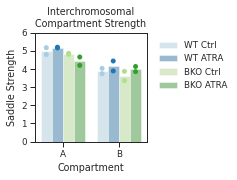

In [71]:
#https://stackoverflow.com/questions/64223870/seaborn-overlap-swarmplot-on-barplot
sns.set_style("ticks")
sns.set_context("paper")
cmap_bar = sns.color_palette(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c'])
gs = GridSpec(nrows= 1, ncols=1, wspace = 0.6, hspace = 0.6)

plt.figure(figsize=(2, 2))

sns.stripplot(x='Compartment', y='Score', hue='Label', dodge=True, data=comp_score_df_trans, jitter = False, palette = cmap_bar)
ax1 = sns.barplot(x='Compartment', y='Score', hue='Label', data=comp_score_df_trans, palette = cmap_bar, alpha = 0.5, ci = False)
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[4:8], labels[4:8], bbox_to_anchor=(1.04,1), loc="upper left", frameon = False)
plt.ylim(0, 6)

plt.title(f'Interchromosomal\nCompartment Strength')
plt.ylabel('Saddle Strength')  
plt.xlabel('Compartment')
        
plt.savefig(f'{outDataDir}/figures/220929_CACollab_HiC_TransCompStrength_AllSamples_BarWithScatter_250kbbinEig1.png', dpi = 300, bbox_inches = "tight")

In [72]:
#Density Plots and Scaling Plots
#https://cooltools.readthedocs.io/en/latest/notebooks/contacts_vs_distance.html

In [73]:
#Calculate expected on 1kb binned coolers

In [74]:
#coolers - 1kb bins
binsize = 1000

clr_paths_1kb = {}
for cond in conditions:
    clr_paths_1kb[cond] = f'{outDataDir}/data/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'

In [128]:
for cond in conditions:
    in_fname = clr_paths_1kb[cond]
    region_fname = f'{outDataDir}/data/hg38_arms_filtered.bed'
    out_fname = f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv'
    !bsub -q short -W 01:00 -e /home/eh37w/lsf_jobs/LSB_%J.err -o /home/eh37w/lsf_jobs/LSB_%J.log \
        -n 8 -R span[hosts=1] -R select[ib] -R rusage[mem=2000] -R select[rh=8] -N -u erica.hildebrand@umassmed.edu \
        "cooltools expected-cis -p 8 -o $out_fname --ignore-diags 2 --view $region_fname $in_fname"

Job <9857571> is submitted to queue <short>.
Job <9857572> is submitted to queue <short>.
Job <9857573> is submitted to queue <short>.
Job <9857574> is submitted to queue <short>.
Job <9857575> is submitted to queue <short>.
Job <9857576> is submitted to queue <short>.
Job <9857577> is submitted to queue <short>.
Job <9857578> is submitted to queue <short>.
Job <9857579> is submitted to queue <short>.
Job <9857580> is submitted to queue <short>.
Job <9857581> is submitted to queue <short>.
Job <9857582> is submitted to queue <short>.


In [75]:
#read in log binned expected for plotting
exp = {}
for cond in conditions:
    exp[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv', sep = '\t')
 

In [76]:
log_exp = {}
for cond in conditions:
    log_exp[cond] = cooltools.api.expected.logbin_expected(
        exp[cond], summary_name='balanced.sum', bins_per_order_magnitude=10, 
        bin_layout='fixed', min_nvalid=200, min_count=50)

In [77]:
log_exp_agg = {}
for cond in conditions:
    log_exp_agg[cond] = cooltools.api.expected.combine_binned_expected(
        log_exp[cond][0], binned_exp_slope=log_exp[cond][1],
        Pc_name='balanced.avg', minmax_drop_bins=2, concat_original=False)

In [78]:
#Add Density column - (balanced.avg * n_valid)/sum(balanced.avg * n_valid)
for cond in conditions:
    log_exp_agg[cond][0]['density'] = (
        log_exp_agg[cond][0]['balanced.avg'] * log_exp_agg[cond][0]['n_valid'])/np.nansum(
        log_exp_agg[cond][0]['balanced.avg'] * log_exp_agg[cond][0]['n_valid'])

In [79]:
log_exp_agg[cond][0].head()

,dist_bin_id,balanced.avg,n_valid,dist.avg,dist_bin_start,dist_bin_end,low_err,high_err,density
0,1,0.015739,1670758,2.000000,2.0,2.0,0.015230,0.016264,0.032779
1,2,0.014765,1663576,3.000000,3.0,3.0,0.014350,0.015192,0.030619
2,3,0.013086,1658441,4.000000,4.0,4.0,0.012742,0.013439,0.027053
3,4,0.011234,1654696,5.000000,5.0,5.0,0.010956,0.011519,0.023172
4,5,0.008970,3304366,6.499931,6.0,7.0,0.008808,0.009134,0.036947


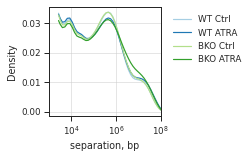

In [80]:
#Smooth density before plotting, on log bins like for scaling. Then convert back to linear so can use semilogx
sns.set_style("ticks")
sns.set_context("paper")

from cooltools.lib import numutils
smoothf = der_smooth_function_combined=lambda x: numutils.robust_gauss_filter(x, 1.3)

f, ax = plt.subplots(
    figsize=(2, 2))

for cond in ComboConds:
    ax.semilogx(
        10**smoothf(np.log10(log_exp_agg[cond][0]['dist.avg']*1000)),
        smoothf(log_exp_agg[cond][0]['density']),
        color = sampleColors[cond],
        label = samplePlotNames[cond],
        ls = sampleLineStyles[cond]
    )

    ax.set(
        xlabel='separation, bp',
        ylabel='Density',
        xlim=(1e3,1e8),
        #ylim=(0, 0.07)
    )

    ax.grid(lw=0.5)
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon = False)
    #ax.set_aspect(100)
    
plt.savefig(f'{outDataDir}/figures/220929_CACollab_R1R2_Density.png', dpi = 300, bbox_inches = "tight")

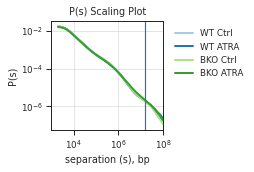

In [81]:
#Plot scaling - combo with line at mitotic dropoff
sns.set_style("ticks")
sns.set_context("paper")

f, ax = plt.subplots(
    figsize=(2, 2))

for cond in ComboConds:
    ax.loglog(
        log_exp_agg[cond][0]['dist.avg']*1000,
        log_exp_agg[cond][0]['balanced.avg'],
        color = sampleColors[cond],
        label = samplePlotNames[cond],
        ls = sampleLineStyles[cond],
        lw = 2
    )

ax.set(
    xlabel='separation (s), bp',
    ylabel='P(s)',
    xlim=(1e3,1e8))

ax.grid(lw=0.5)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon = False)
plt.title('P(s) Scaling Plot')

plt.axvline(x=1.5e7)
    
plt.savefig(f'{outDataDir}/figures/220929_CACollab_R1R2_Scaling_Combo_With1.5e7vline.png', dpi = 300, bbox_inches = "tight")

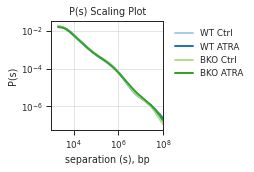

In [82]:
#Plot scaling - combo 
sns.set_style("ticks")
sns.set_context("paper")

f, ax = plt.subplots(
    figsize=(2, 2))

for cond in ComboConds:
    ax.loglog(
        log_exp_agg[cond][0]['dist.avg']*1000,
        log_exp_agg[cond][0]['balanced.avg'],
        color = sampleColors[cond],
        label = samplePlotNames[cond],
        ls = sampleLineStyles[cond],
        lw = 2
    )

ax.set(
    xlabel='separation (s), bp',
    ylabel='P(s)',
    xlim=(1e3,1e8))

ax.grid(lw=0.5)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon = False)
plt.title('P(s) Scaling Plot')
    
plt.savefig(f'{outDataDir}/figures/220929_CACollab_R1R2_Scaling_Combo.png', dpi = 300, bbox_inches = "tight")

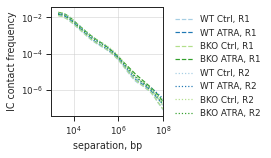

In [83]:
#Plot scaling and slope separately
sns.set_style("ticks")
sns.set_context("paper")

f, ax = plt.subplots(
    figsize=(2, 2))

for cond in SepConds:
    ax.loglog(
        log_exp_agg[cond][0]['dist.avg']*1000,
        log_exp_agg[cond][0]['balanced.avg'],
        color = sampleColors[cond],
        label = samplePlotNames[cond],
        linestyle = sampleLineStyles[cond]
    )

    ax.set(
        xlabel='separation, bp',
        ylabel='IC contact frequency',
        xlim=(1e3,1e8)
    )
    #ax.set_aspect(1.0)
    ax.grid(lw=0.5)
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon = False)
    
plt.savefig(f'{outDataDir}/figures/220929_CACollab_R1R2_Scaling_Separate.png', dpi = 300, bbox_inches = "tight")

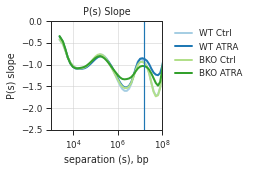

In [84]:
#Plot slope - combo
sns.set_style("ticks")
sns.set_context("paper")

f, ax = plt.subplots(
    figsize=(2, 2))

for cond in ComboConds:
    ax.semilogx(
        log_exp_agg[cond][1]['dist.avg']*1000,
        log_exp_agg[cond][1]['slope'],
        color = sampleColors[cond],
        label = samplePlotNames[cond],
        ls = sampleLineStyles[cond],
        lw = 2
    )

ax.set(
    xlabel='separation (s), bp',
    ylabel='P(s) slope',
    ylim=(-2.5, 0),
    xlim=(1e3,1e8)
    )

ax.grid(lw=0.5)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon = False)
plt.title('P(s) Slope')
plt.axvline(x=1.5e7)
    
plt.savefig(f'{outDataDir}/figures/220929_CACollab_ScalingSlope_Combo_With1.5e7vline.png', dpi = 300, bbox_inches = "tight")

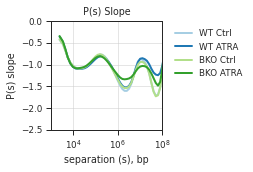

In [85]:
#Plot slope - combo
sns.set_style("ticks")
sns.set_context("paper")

f, ax = plt.subplots(
    figsize=(2, 2))

for cond in ComboConds:
    ax.semilogx(
        log_exp_agg[cond][1]['dist.avg']*1000,
        log_exp_agg[cond][1]['slope'],
        color = sampleColors[cond],
        label = samplePlotNames[cond],
        ls = sampleLineStyles[cond],
        lw = 2
    )

ax.set(
    xlabel='separation (s), bp',
    ylabel='P(s) slope',
    ylim=(-2.5, 0),
    xlim=(1e3,1e8)
    )

ax.grid(lw=0.5)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon = False)

plt.title('P(s) Slope')
    
plt.savefig(f'{outDataDir}/figures/220929_CACollab_ScalingSlope_Combo.png', dpi = 300, bbox_inches = "tight")

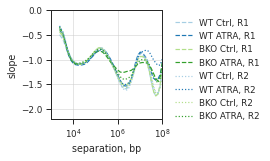

In [86]:
#Plot scaling and slope separately
sns.set_style("ticks")
sns.set_context("paper")

f, ax = plt.subplots(
    figsize=(2, 2))

for cond in SepConds:
    ax.semilogx(
        log_exp_agg[cond][1]['dist.avg']*1000,
        log_exp_agg[cond][1]['slope'],
        color = sampleColors[cond],
        label = samplePlotNames[cond],
        linestyle = sampleLineStyles[cond]
    )

    ax.set(
        xlabel='separation, bp',
        ylabel='slope',
        ylim=(-2.2, 0),
        xlim=(1e3,1e8)
    )

    ax.grid(lw=0.5)
    #ax.set_aspect(1)
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon = False)
    
plt.savefig(f'{outDataDir}/figures/220929_CACollab_R1R2_ScalingSlope_Separate.png', dpi = 300, bbox_inches = "tight")

In [87]:
#Call insulation, pileup at control boundaries

In [88]:
#coolers - 10kb bins
binsize = 10000

clr_paths_10kb = {}
for cond in conditions:
    clr_paths_10kb[cond] = f'{outDataDir}/data/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'
    
clrs10kb = {
    cond: cooler.Cooler(clr_paths_10kb[cond]) for cond in conditions
}

In [89]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)

In [90]:
# Select only chromosomes that are present in the good chromosomes
hg38_chromsizes = hg38_chromsizes.loc[good_chroms]
hg38_arms = hg38_arms[hg38_arms.chrom.isin(good_chroms)].reset_index(drop=True)
hg38_chrom_vf = bioframe.make_viewframe(hg38_chromsizes)

In [91]:
#call insulation
insulation_table = {}

for cond in conditions:
    insulation_table[cond] = insulation(clrs10kb[cond], 250000, verbose=False, ignore_diags = 2, view_df=hg38_chrom_vf)

In [92]:
insulation_table[cond]

,chrom,start,end,region,is_bad_bin,log2_insulation_score_250000,n_valid_pixels_250000,boundary_strength_250000,is_boundary_250000
0,chr1,0,10000,chr1,True,NaN,0.0,NaN,False
1,chr1,10000,20000,chr1,True,NaN,0.0,NaN,False
2,chr1,20000,30000,chr1,True,NaN,0.0,NaN,False
3,chr1,30000,40000,chr1,True,NaN,0.0,NaN,False
4,chr1,40000,50000,chr1,True,NaN,0.0,NaN,False
...,...,...,...,...,...,...,...,...,...
282422,chr21,46660000,46670000,chr21,False,1.234846,47.0,NaN,False
282423,chr21,46670000,46680000,chr21,False,1.375304,23.0,NaN,False
282424,chr21,46680000,46690000,chr21,True,NaN,0.0,NaN,False
282425,chr21,46690000,46700000,chr21,True,NaN,0.0,NaN,False


In [93]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

/tmp/ipykernel_3202445/3828392577.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


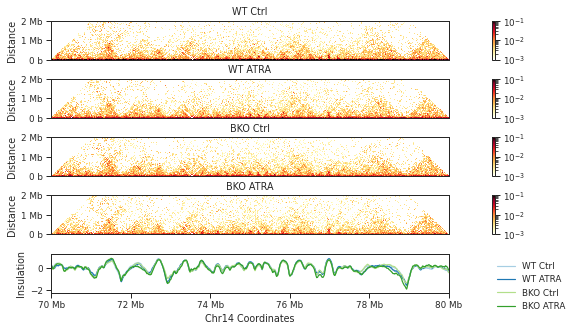

In [94]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid import make_axes_locatable
import bioframe

sns.set_style("ticks")
sns.set_context("paper")

fig = plt.figure(figsize=(8, 5))

gs0 = GridSpec(nrows = 5, ncols = 2, width_ratios = [50, 1], hspace = 0.5)

for i, cond in enumerate(ComboConds):
    ax = plt.subplot(gs0[i, 0])
    region = ('chr14', 70000000, 80000000)
    norm = LogNorm(vmax=0.1, vmin=0.001)
    data = clrs10kb[cond].matrix(balance=True).fetch(region)
    im = pcolormesh_45deg(ax, data, start=region[1], resolution=10000, norm=norm, cmap='fall')
    ax.set_ylim(0, 2000000)
    format_ticks(ax, rotate=False)
    ax.xaxis.set_visible(False)
    ax.set_xlim(region[1], region[2])
    plt.title(samplePlotNames[cond])
    plt.ylabel('Distance')

    #divider = make_axes_locatable(ax)
    cax = plt.subplot(gs0[i, 1])
    plt.colorbar(im, cax=cax)
    cax.set_aspect(6)

#ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)
    
for cond in ComboConds:
    ins_ax = plt.subplot(gs0[4, 0])
    insul_region = bioframe.select(insulation_table[cond], region)
    ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), 
                insul_region['log2_insulation_score_250000'], 
                label=samplePlotNames[cond], color = sampleColors[cond])
    plt.ylim(-2.25, 1.25)
    format_ticks(ins_ax, y=False, rotate=False)
    ins_ax.legend().set_visible(False)
    ins_ax.set_xlim(region[1], region[2])
    plt.ylabel('Insulation')
    plt.xlabel('Chr14 Coordinates')
    
    h, l = ins_ax.get_legend_handles_labels() # get labels and handles
    leg_ax = plt.subplot(gs0[4, 1])
    leg_ax.legend(h, l, frameon = False, bbox_to_anchor=(0, 1), loc="upper left")  
    leg_ax.axis('off')
    
plt.savefig(f'{outDataDir}/figures/220929_All_insulation_example.png', dpi = 300, bbox_inches = 'tight')

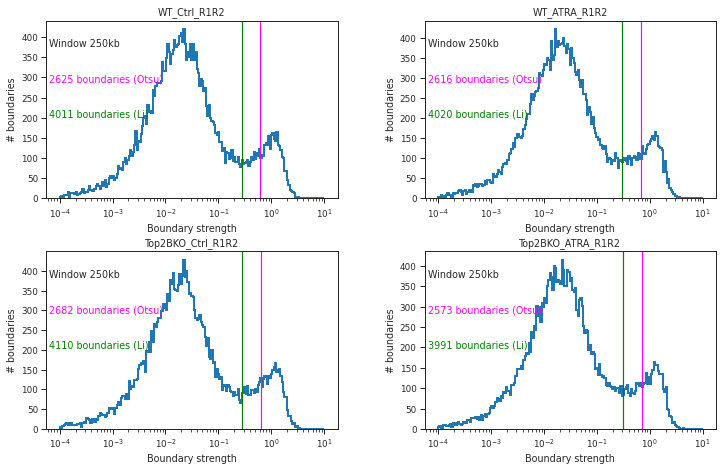

In [95]:
from skimage.filters import threshold_li, threshold_otsu
windows = [250000]
histkwargs = dict(
    bins=10**np.linspace(-4,1,200),
    histtype='step',
    lw=2,
)

fig = plt.figure(figsize=(12, 16))

gs0 = GridSpec(nrows = 4, ncols = 2, wspace=0.3, hspace = 0.3)

thresholds_li = {}
thresholds_otsu = {}
bounds_li = {}
bounds_otsu = {}

for i, cond in enumerate(ComboConds):
    gs1 = GridSpecFromSubplotSpec(nrows=len(windows), ncols=1, wspace = 0.3, hspace = 1, subplot_spec = gs0[i])

    thresholds_li[cond] = {}
    thresholds_otsu[cond] = {}
    bounds_li[cond] = {}
    bounds_otsu[cond] = {}

    for i, w in enumerate(windows):
        ax = plt.subplot(gs1[i])
        ax.hist(
            insulation_table[cond][f'boundary_strength_{w}'],
            **histkwargs
        )
        thresholds_li[cond][w] = threshold_li(insulation_table[cond][f'boundary_strength_{w}'].dropna().values)
        thresholds_otsu[cond][w] = threshold_otsu(insulation_table[cond][f'boundary_strength_{w}'].dropna().values)
        n_boundaries_li = (insulation_table[cond][f'boundary_strength_{w}'].dropna()>=thresholds_li[cond][w]).sum()
        bounds_li[cond][w] = insulation_table[cond][(insulation_table[cond][f'boundary_strength_{w}']>=thresholds_li[cond][w])]
        n_boundaries_otsu = (insulation_table[cond][f'boundary_strength_{w}'].dropna()>=thresholds_otsu[cond][w]).sum()
        bounds_otsu[cond][w] = insulation_table[cond][(insulation_table[cond][f'boundary_strength_{w}']>=thresholds_otsu[cond][w])]

        ax.axvline(thresholds_li[cond][w], c='green')
        ax.axvline(thresholds_otsu[cond][w], c='magenta')
        ax.text(0.01, 0.9,
                 f'Window {w//1000}kb',
                 ha='left',
                 va='top',
                 transform=ax.transAxes)
        ax.text(0.01, 0.7,
                f'{n_boundaries_otsu} boundaries (Otsu)',
                c='magenta',
                ha='left',
                va='top',
                transform=ax.transAxes)
        ax.text(0.01, 0.5,
                f'{n_boundaries_li} boundaries (Li)',
                c='green',
                ha='left',
                va='top',
                transform=ax.transAxes)

        ax.set(
            xscale='log',
            ylabel='# boundaries'
        )

        ax.set(xlabel='Boundary strength')
        plt.title(cond)
    
plt.savefig(f'{outDataDir}/figures/220929_CACollab_AllCond_BoundaryThresholds.png', dpi = 300, 
            bbox_inches = 'tight')

In [96]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')

In [97]:
hg38_chromsizes = hg38_chromsizes.loc[good_chroms]

In [98]:
for cond in conditions:
    for w in windows:
        bioframe.to_bigwig(insulation_table[cond], hg38_chromsizes,
            f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.insul_score_{w}.bw', 
            f'log2_insulation_score_{w}')

In [99]:
import bbi

In [100]:
# Create stackup. flank = .5Mb, nbins = 100, 250kb window, 10kb hi-c resolution
flank = 500000 # Length of flank to one side from the boundary, in basepairs
nbins = 100   # Number of bins to split the region
ins_pileup_signal = {}
for cond in conditions:
    ins_pileup_signal[cond] = bbi.stackup(
        f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.insul_score_250000.bw',
        bounds_otsu['WT_Ctrl_R1R2'][250000].chrom,
        bounds_otsu['WT_Ctrl_R1R2'][250000].start-flank,
        bounds_otsu['WT_Ctrl_R1R2'][250000].end+flank, bins=nbins)

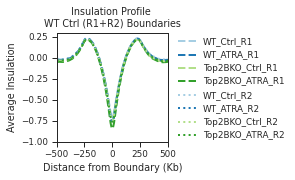

In [101]:
sns.set_style("ticks")
sns.set_context("paper")

f, ax = plt.subplots(figsize=[2, 2])
flank = 500000
nbins = 100
x = np.linspace(-flank/1e3, flank/1e3, nbins)
for cond in SepConds:
    ax.plot(x, np.nanmean(ins_pileup_signal[cond], axis=0), color = sampleColors[cond], label = cond, 
            ls = sampleLineStyles[cond], lw = 2)
plt.xlim(-flank/1e3, flank/1e3)
plt.ylim(-1, .3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1, frameon = False)
plt.title('Insulation Profile \nWT Ctrl (R1+R2) Boundaries')
plt.ylabel('Average Insulation')
plt.xlabel('Distance from Boundary (Kb)')
plt.savefig(f'{outDataDir}/figures/220929_CACollab_InsulationPileup_WTCtrlR1R2Boundaries.png', dpi = 300, 
            bbox_inches = 'tight')

In [102]:
#separate out TAD vs Compartment boundaries

In [103]:
#called boundaries from cooler compartments (with gene density)
binsize_comp = 250000

eigs = {}
for cond in conditions:
    eigs[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize_comp//1000}kb.mapq30.byarm.eigs.cis.vecs.txt', sep='\t')

#calling A vs B compartments in each sample
eigsA = {}
for cond in conditions:
    eigsA[cond] = eigs[cond][eigs[cond]['E1'] > 0]
    
eigsB = {}
for cond in conditions:
    eigsB[cond] = eigs[cond][eigs[cond]['E1'] < 0]

compRangesA = {}
for cond in conditions:
    compRangesA[cond] = bioframe.merge(pd.DataFrame(data = {
        'chrom' : eigsA[cond].chrom,
        'start' : eigsA[cond].start,
        'end' : eigsA[cond].end,
        'name' : '.',
        'score' : '.',
        'strand' : '+'
    }))
    
compRangesB = {}
for cond in conditions:
    compRangesB[cond] = bioframe.merge(pd.DataFrame(data = {
        'chrom' : eigsB[cond].chrom,
        'start' : eigsB[cond].start,
        'end' : eigsB[cond].end,
        'name' : '.',
        'score' : '.',
        'strand' : '+'
    }))

In [104]:
#calling compartment boundaries in each sample
#Calculate which bins flank sign changes - on same chromosome. 

compBounds = {}
signsAll = {}

for cond in conditions:    
    signsAll[cond] = pd.DataFrame(data = {
        'Chrom1' : eigs[cond]['chrom'][0:-1].reset_index(drop = True),
        'Bin1Start' : eigs[cond]['start'][0:-1].reset_index(drop = True),
        'Bin1End' : eigs[cond]['end'][0:-1].reset_index(drop = True),
        'Bin1E1' : eigs[cond]['E1'][0:-1].reset_index(drop = True),
        'Chrom2' : eigs[cond]['chrom'][1:].reset_index(drop = True),
        'Bin2Start' : eigs[cond]['start'][1:].reset_index(drop = True),
        'Bin2End' : eigs[cond]['end'][1:].reset_index(drop = True),  
        'Bin2E1' : eigs[cond]['E1'][1:].reset_index(drop = True),
        'sign' : (eigs[cond]['E1'][0:-1].reset_index(drop = True) * eigs[cond]['E1'][1:].reset_index(drop = True))
        })
    signsAll[cond].apply(pd.to_numeric, errors='ignore')
    signsAll[cond] = signsAll[cond].astype({"Bin1Start": int, "Bin1End": int, "Bin2Start": int, "Bin2End": int})

    compBounds[cond] = signsAll[cond][(signsAll[cond]['sign'] < 0) &
                                      (signsAll[cond]['Chrom1'] == signsAll[cond]['Chrom2']) 
                                     ]

In [105]:
compBoundsRanges = {}
for cond in conditions:
    compBoundsRanges[cond] = pd.DataFrame(data = {
        'chrom' : compBounds[cond].Chrom1,
        'start' : compBounds[cond].Bin1Start,
        'end' : compBounds[cond].Bin2End,
        'name' : '.',
        'score' : compBounds[cond].sign,
        'strand' : '+'
    })

In [106]:
compBoundsRanges['WT_Ctrl_R1R2']

,chrom,start,end,name,score,strand
10,chr1,2500000,3000000,.,-0.264305,+
13,chr1,3250000,3750000,.,-0.062566,+
15,chr1,3750000,4250000,.,-0.086449,+
23,chr1,5750000,6250000,.,-0.186504,+
49,chr1,12250000,12750000,.,-0.018624,+
...,...,...,...,...,...,...
11277,chr21,39000000,39500000,.,-0.010460,+
11278,chr21,39250000,39750000,.,-0.055788,+
11291,chr21,42500000,43000000,.,-0.003331,+
11298,chr21,44250000,44750000,.,-0.036093,+


In [107]:
bounds_otsu[cond][250000]

,chrom,start,end,region,is_bad_bin,log2_insulation_score_250000,n_valid_pixels_250000,boundary_strength_250000,is_boundary_250000
169,chr1,1690000,1700000,chr1,True,-0.355883,506.0,0.833805,True
191,chr1,1910000,1920000,chr1,False,-0.469398,547.0,1.164606,True
240,chr1,2400000,2410000,chr1,False,-0.378468,622.0,0.867976,True
342,chr1,3420000,3430000,chr1,False,-1.014783,622.0,1.366010,True
390,chr1,3900000,3910000,chr1,False,-1.463604,622.0,2.510888,True
...,...,...,...,...,...,...,...,...,...
282008,chr21,42520000,42530000,chr21,False,-0.359417,622.0,0.757171,True
282134,chr21,43780000,43790000,chr21,False,-0.193237,547.0,0.882208,True
282234,chr21,44780000,44790000,chr21,False,-0.575542,622.0,1.401319,True
282310,chr21,45540000,45550000,chr21,False,-0.535185,622.0,1.125450,True


In [108]:
tadOnlyBoundaries = {}
overlapCompBoundaries = {}

for cond in ComboConds:
    insBoundaries = bounds_otsu[cond][250000].copy()
    compBoundaries = compBoundsRanges[cond].copy()
    overlapBounds = bioframe.overlap(insBoundaries, compBoundaries, how = 'inner').iloc[:, 0:4]
    overlapBounds.columns = ['chrom', 'start', 'end', 'boundary_strength_250000']
    overlapCompBoundaries[cond] = overlapBounds.drop_duplicates()
    tadOnlyBoundaries[cond] = bioframe.subtract(insBoundaries, overlapCompBoundaries[cond]).drop_duplicates()

In [109]:
#save the comp vs tad insulation boundaries, and all insulation boundaries
for cond in ComboConds:
    overlapCompBoundaries[cond].to_csv(
        f'{outDataDir}/data/{long_names[cond]}.compartmentOverlap_insulation_250kbWindow_bounds.mapq30.goodchroms.arms.txt',
        sep = "\t", index = False)
    tadOnlyBoundaries[cond].to_csv(    
        f'{outDataDir}/data/{long_names[cond]}.TADonly_insulation_250kbWindow_bounds.mapq30.goodchroms.arms.txt',
        sep = "\t", index = False)
    bounds_otsu[cond][250000].to_csv(    
        f'{outDataDir}/data/{long_names[cond]}.AllBounds_insulation_250kbWindow_bounds.mapq30.goodchroms.arms.txt',
        sep = "\t", index = False)

In [110]:
#read in comp vs tad insulation boundaries
tadOnlyBoundaries = {}
overlapCompBoundaries = {}

for cond in ComboConds:
    overlapCompBoundaries[cond] = pd.read_csv(
        f'{outDataDir}/data/{long_names[cond]}.compartmentOverlap_insulation_250kbWindow_bounds.mapq30.goodchroms.arms.txt',
        sep = "\t")
    tadOnlyBoundaries[cond] = pd.read_csv(    
        f'{outDataDir}/data/{long_names[cond]}.TADonly_insulation_250kbWindow_bounds.mapq30.goodchroms.arms.txt',
        sep = "\t")
    

In [111]:
# Create stackup. flank = .5Mb, nbins = 100, 250kb window, 10kb hi-c resolution, TAD only boundaries
flank = 500000 # Length of flank to one side from the boundary, in basepairs
nbins = 100   # Number of bins to split the region
ins_pileup_signal_TAD = {}
for cond in conditions:
    ins_pileup_signal_TAD[cond] = bbi.stackup(
        f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.insul_score_250000.bw',
        tadOnlyBoundaries['WT_Ctrl_R1R2'].chrom,
        tadOnlyBoundaries['WT_Ctrl_R1R2'].start-flank,
        tadOnlyBoundaries['WT_Ctrl_R1R2'].end+flank, bins=nbins)

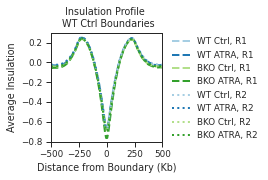

In [112]:
sns.set_style("ticks")
sns.set_context("paper")
f, ax = plt.subplots(figsize=[2, 2])
flank = 500000
nbins = 100
x = np.linspace(-flank/1e3, flank/1e3, nbins)
for cond in SepConds:
    ax.plot(x, np.nanmean(ins_pileup_signal_TAD[cond], axis=0), color = sampleColors[cond], label = samplePlotNames[cond], 
            ls = sampleLineStyles[cond], lw = 2)
plt.xlim(-flank/1e3, flank/1e3)
plt.ylim(-.8, .3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1, frameon = False)
plt.title('Insulation Profile \n WT Ctrl Boundaries')
plt.ylabel('Average Insulation')
plt.xlabel('Distance from Boundary (Kb)')
plt.savefig(f'{outDataDir}/figures/220929_CACollab_InsulationPileup_WTCtrlR1R2TADBoundaries.png', dpi = 300, 
            bbox_inches = 'tight')

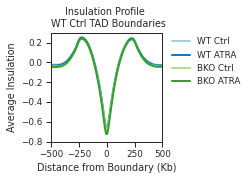

In [113]:
sns.set_style("ticks")
sns.set_context("paper")
f, ax = plt.subplots(figsize=[2, 2])
flank = 500000
nbins = 100
x = np.linspace(-flank/1e3, flank/1e3, nbins)
for cond in ComboConds:
    ax.plot(x, np.nanmean(ins_pileup_signal_TAD[cond], axis=0), color = sampleColors[cond], label = samplePlotNames[cond], 
            ls = sampleLineStyles[cond], lw = 2)
plt.xlim(-flank/1e3, flank/1e3)
plt.ylim(-.8, .3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1, frameon = False)
plt.title('Insulation Profile \n WT Ctrl TAD Boundaries')
plt.ylabel('Average Insulation')
plt.xlabel('Distance from Boundary (Kb)')
plt.savefig(f'{outDataDir}/figures/220929_CACollab_InsulationPileup_WTCtrlR1R2TADBoundaries_Combo.png', dpi = 300, 
            bbox_inches = 'tight')

In [114]:
#1kb bins - coverage in cis vs total

In [115]:
#coolers - 1kb bins
binsize = 1000

clr_paths_1kb = {}
for cond in conditions:
    clr_paths_1kb[cond] = f'{outDataDir}/data/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'
    
clrs1kb = {
    cond: cooler.Cooler(clr_paths_1kb[cond]) for cond in conditions
}

In [116]:
clrs1kb['WT_Ctrl_R1'].info

{'bin-size': 1000,
 'bin-type': 'fixed',
 'creation-date': '2022-09-10T14:52:34.827473',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/open2c/cooler',
 'format-version': 3,
 'generated-by': 'cooler-0.8.11',
 'genome-assembly': 'unknown',
 'metadata': {},
 'nbins': 3088298,
 'nchroms': 25,
 'nnz': 27623832,
 'storage-mode': 'symmetric-upper',
 'sum': 32523871}

In [117]:
ciscov = {}
totcov = {}
for cond in conditions:
    ciscov[cond], totcov[cond] = cooltools.api.coverage.coverage(
        clrs1kb[cond], 
        ignore_diags=2, 
        chunksize=10000000)

In [118]:
#total sum is not the same as sum/count from cooler unless don't ignore 2 diags, but then cis % is not right (since not balanced)

In [119]:
ciscov[cond]

array([  0.,   0.,   0., ..., 671., 539., 552.])

In [120]:
#cis/trans - all chromosomes, ignore first 2 diags, from coolers
cisratio = {}
for cond in conditions:
    cisratio[cond] = sum(ciscov[cond])/(sum(totcov[cond])-sum(ciscov[cond]))

In [121]:
#Plot bargraph of avg and dots of replicates for cis ratio

cis_ratio_df = pd.DataFrame(columns = ['Condition', 'Replicate', 'Label', 'Ratio'])


In [122]:
for cond in SepConds:
    cis_ratio_df = cis_ratio_df.append({
                'Condition' : f'{cond}', 
                'Replicate' : repdict[cond], 
                'Label' : f'{labeldict[cond]}',
                'Ratio' : cisratio[cond]
            }, ignore_index = True)
    

/tmp/ipykernel_3202445/2722586424.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cis_ratio_df = cis_ratio_df.append({
/tmp/ipykernel_3202445/2722586424.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cis_ratio_df = cis_ratio_df.append({
/tmp/ipykernel_3202445/2722586424.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cis_ratio_df = cis_ratio_df.append({
/tmp/ipykernel_3202445/2722586424.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cis_ratio_df = cis_ratio_df.append({
/tmp/ipykernel_3202445/2722586424.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

In [123]:
cis_ratio_df

,Condition,Replicate,Label,Ratio
0,WT_Ctrl_R1,R1,WT Ctrl,7.502132
1,WT_ATRA_R1,R1,WT ATRA,7.224734
2,Top2BKO_Ctrl_R1,R1,BKO Ctrl,7.47634
3,Top2BKO_ATRA_R1,R1,BKO ATRA,6.400773
4,WT_Ctrl_R2,R2,WT Ctrl,7.558399
5,WT_ATRA_R2,R2,WT ATRA,6.28405
6,Top2BKO_Ctrl_R2,R2,BKO Ctrl,7.710959
7,Top2BKO_ATRA_R2,R2,BKO ATRA,6.991178


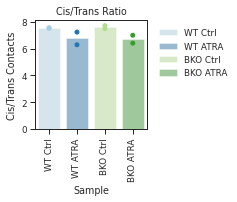

In [124]:
#https://stackoverflow.com/questions/64223870/seaborn-overlap-swarmplot-on-barplot
sns.set_style("ticks")
sns.set_context("paper")
cmap_bar = sns.color_palette(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c'])
gs = GridSpec(nrows= 1, ncols=1, wspace = 0.6, hspace = 0.6)

plt.figure(figsize=(2, 2))

ax = plt.subplot(gs[0])

sns.stripplot(
    x='Label',
    y='Ratio',
    hue='Label', 
    dodge=False, 
    data=cis_ratio_df, 
    jitter = False, 
    palette = cmap_bar, 
    ax = ax)
ax1 = sns.barplot(
    x='Label', 
    y='Ratio', 
    hue='Label', 
    data=cis_ratio_df,
    palette = cmap_bar, 
    alpha = 0.5, 
    dodge = False,
    ci = False, 
    ax = ax)
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[4:8], labels[4:8], bbox_to_anchor=(1.04,1), frameon = False)
 
plt.title(f'Cis/Trans Ratio')
plt.ylabel('Cis/Trans Contacts')  
#plt.ylim(0, 1)
plt.xlabel('Sample')
plt.xticks(rotation=90)
        
plt.savefig(f'{outDataDir}/figures/220929_CACollab_R1R2_HiC_CisvsTransRatio_BarWithScatter.png', dpi = 300, bbox_inches = "tight")

In [125]:
#cis/trans - all chromosomes, ignore first 2 diags, from coolers
cisratio = {}
for cond in conditions:
    cisratio[cond] = sum(ciscov[cond])/sum(totcov[cond])

In [126]:
#Plot bargraph of avg and dots of replicates for cis ratio

cis_ratio_df = pd.DataFrame(columns = ['Condition', 'Replicate', 'Label', 'Ratio'])


In [127]:
for cond in SepConds:
    cis_ratio_df = cis_ratio_df.append({
                'Condition' : f'{cond}', 
                'Replicate' : repdict[cond], 
                'Label' : f'{labeldict[cond]}',
                'Ratio' : cisratio[cond]
            }, ignore_index = True)
    

/tmp/ipykernel_3202445/2722586424.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cis_ratio_df = cis_ratio_df.append({
/tmp/ipykernel_3202445/2722586424.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cis_ratio_df = cis_ratio_df.append({
/tmp/ipykernel_3202445/2722586424.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cis_ratio_df = cis_ratio_df.append({
/tmp/ipykernel_3202445/2722586424.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cis_ratio_df = cis_ratio_df.append({
/tmp/ipykernel_3202445/2722586424.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

In [128]:
cis_ratio_df

,Condition,Replicate,Label,Ratio
0,WT_Ctrl_R1,R1,WT Ctrl,0.882382
1,WT_ATRA_R1,R1,WT ATRA,0.878416
2,Top2BKO_Ctrl_R1,R1,BKO Ctrl,0.882025
3,Top2BKO_ATRA_R1,R1,BKO ATRA,0.864879
4,WT_Ctrl_R2,R2,WT Ctrl,0.883156
5,WT_ATRA_R2,R2,WT ATRA,0.862714
6,Top2BKO_Ctrl_R2,R2,BKO Ctrl,0.885202
7,Top2BKO_ATRA_R2,R2,BKO ATRA,0.874862


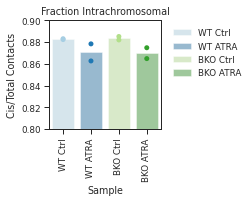

In [129]:
#https://stackoverflow.com/questions/64223870/seaborn-overlap-swarmplot-on-barplot
sns.set_style("ticks")
sns.set_context("paper")
cmap_bar = sns.color_palette(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c'])
gs = GridSpec(nrows= 1, ncols=1, wspace = 0.6, hspace = 0.6)

plt.figure(figsize=(2, 2))

ax = plt.subplot(gs[0])

sns.stripplot(
    x='Label',
    y='Ratio',
    hue='Label', 
    dodge=False, 
    data=cis_ratio_df, 
    jitter = False, 
    palette = cmap_bar, 
    ax = ax)
ax1 = sns.barplot(
    x='Label', 
    y='Ratio', 
    hue='Label', 
    data=cis_ratio_df,
    palette = cmap_bar, 
    alpha = 0.5, 
    dodge = False,
    ci = False, 
    ax = ax)
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[4:8], labels[4:8], bbox_to_anchor=(1.04,1), frameon = False)
 
plt.title(f'Fraction Intrachromosomal')
plt.ylabel('Cis/Total Contacts')  
plt.ylim(0.8, 0.9)
plt.xlabel('Sample')
plt.xticks(rotation=90)
        
plt.savefig(f'{outDataDir}/figures/220929_CACollab_R1R2_HiC_CisvsTotalRatio_BarWithScatter.png', dpi = 300, bbox_inches = "tight")